<a href="https://colab.research.google.com/github/Leandro-Custodio/Energy-consumption-study-in-Balneario-Camboriu/blob/main/Energy_consumption_study_in_Balneario_Camboriu_Public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TIME SERIES consumo de energia em Balneario Camboriú de 1994 a 2023

## Pré-Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from pandas import concat
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from time import time
import warnings
warnings.filterwarnings("ignore")

In [4]:
df_celesc_geral = pd.read_excel('/content/drive/MyDrive/Leandro_PPGESE/Referencias/Smart_metering/Dataset/Energy_Consumption_Celesc/energy_consumption_12_2023.xlsx')
df_celesc_geral_residencial = df_celesc_geral[df_celesc_geral.cod_classe == 1]
df_celesc_geral_residencial.head()

,tipo,cod_muni,agência,núcleo,unidade,município,cod_classe,classe,1994-01-01 00:00:00,1994-02-01 00:00:00,...,2023-03-01 00:00:00,2023-04-01 00:00:00,2023-05-01 00:00:00,2023-06-01 00:00:00,2023-07-01 00:00:00,2023-08-01 00:00:00,2023-09-01 00:00:00,2023-10-01 00:00:00,2023-11-01 00:00:00,2023-12-01 00:00:00
0,Cativo,17106,ARITA,Núcleo Leste,Itajaí (sede),Balneário Camboriú,1,Residencial,5537.369,7559.651,...,24990.585,21987.443,16557.935,16040.536,15412.302,14192.559,14927.108,17170.48,15416.7,19555.624


In [5]:
listZero = range(8, 19) # remove de 01-1994 a 11-1994 pois estão nulos
df_celesc_geral_residencial = df_celesc_geral_residencial[df_celesc_geral_residencial.município == 'Balneário Camboriú'].drop(df_celesc_geral_residencial.columns[listZero], axis=1)
df_celesc_geral_residencial.head()

,tipo,cod_muni,agência,núcleo,unidade,município,cod_classe,classe,1994-12-01 00:00:00,1995-01-01 00:00:00,...,2023-03-01 00:00:00,2023-04-01 00:00:00,2023-05-01 00:00:00,2023-06-01 00:00:00,2023-07-01 00:00:00,2023-08-01 00:00:00,2023-09-01 00:00:00,2023-10-01 00:00:00,2023-11-01 00:00:00,2023-12-01 00:00:00
0,Cativo,17106,ARITA,Núcleo Leste,Itajaí (sede),Balneário Camboriú,1,Residencial,4352.471,6272.489,...,24990.585,21987.443,16557.935,16040.536,15412.302,14192.559,14927.108,17170.48,15416.7,19555.624


### Transformando em Dataframe

In [6]:
valor_12_2023 = df_celesc_geral_residencial.values[0][356]
print("Valor Original de 12/2023", valor_12_2023)

Valor Original de 12/2023 19555.624


##### Valor Original de 12/2023 19555.624

In [7]:
list_date_valid = range(8, 356)

time_seriesf_residencial = []
for date_value in list_date_valid:
  time_seriesf_residencial.append([pd.to_datetime(df_celesc_geral_residencial.columns[[date_value]].values[0]), df_celesc_geral_residencial.values[0][date_value]])


time_seriesf_residencial = pd.DataFrame(time_seriesf_residencial, columns=['date','consumo_mensal'])
time_seriesf_residencial['index_date'] = pd.to_datetime(time_seriesf_residencial['date'])
time_seriesf_residencial.set_index('index_date', inplace=True)
time_seriesf_residencial.index.freq = 'MS'
time_seriesf_residencial["month"] = time_seriesf_residencial.index.month
time_seriesf_residencial.head()

,date,consumo_mensal,month
index_date,,,
1994-12-01,1994-12-01,4352.471,12
1995-01-01,1995-01-01,6272.489,1
1995-02-01,1995-02-01,8523.133,2
1995-03-01,1995-03-01,6667.975,3
1995-04-01,1995-04-01,5181.387,4


In [8]:
time_seriesf_residencial.tail()

,date,consumo_mensal,month
index_date,,,
2023-07-01,2023-07-01,15412.302,7
2023-08-01,2023-08-01,14192.559,8
2023-09-01,2023-09-01,14927.108,9
2023-10-01,2023-10-01,17170.480,10
2023-11-01,2023-11-01,15416.700,11


# Grafico Geral do Consumo

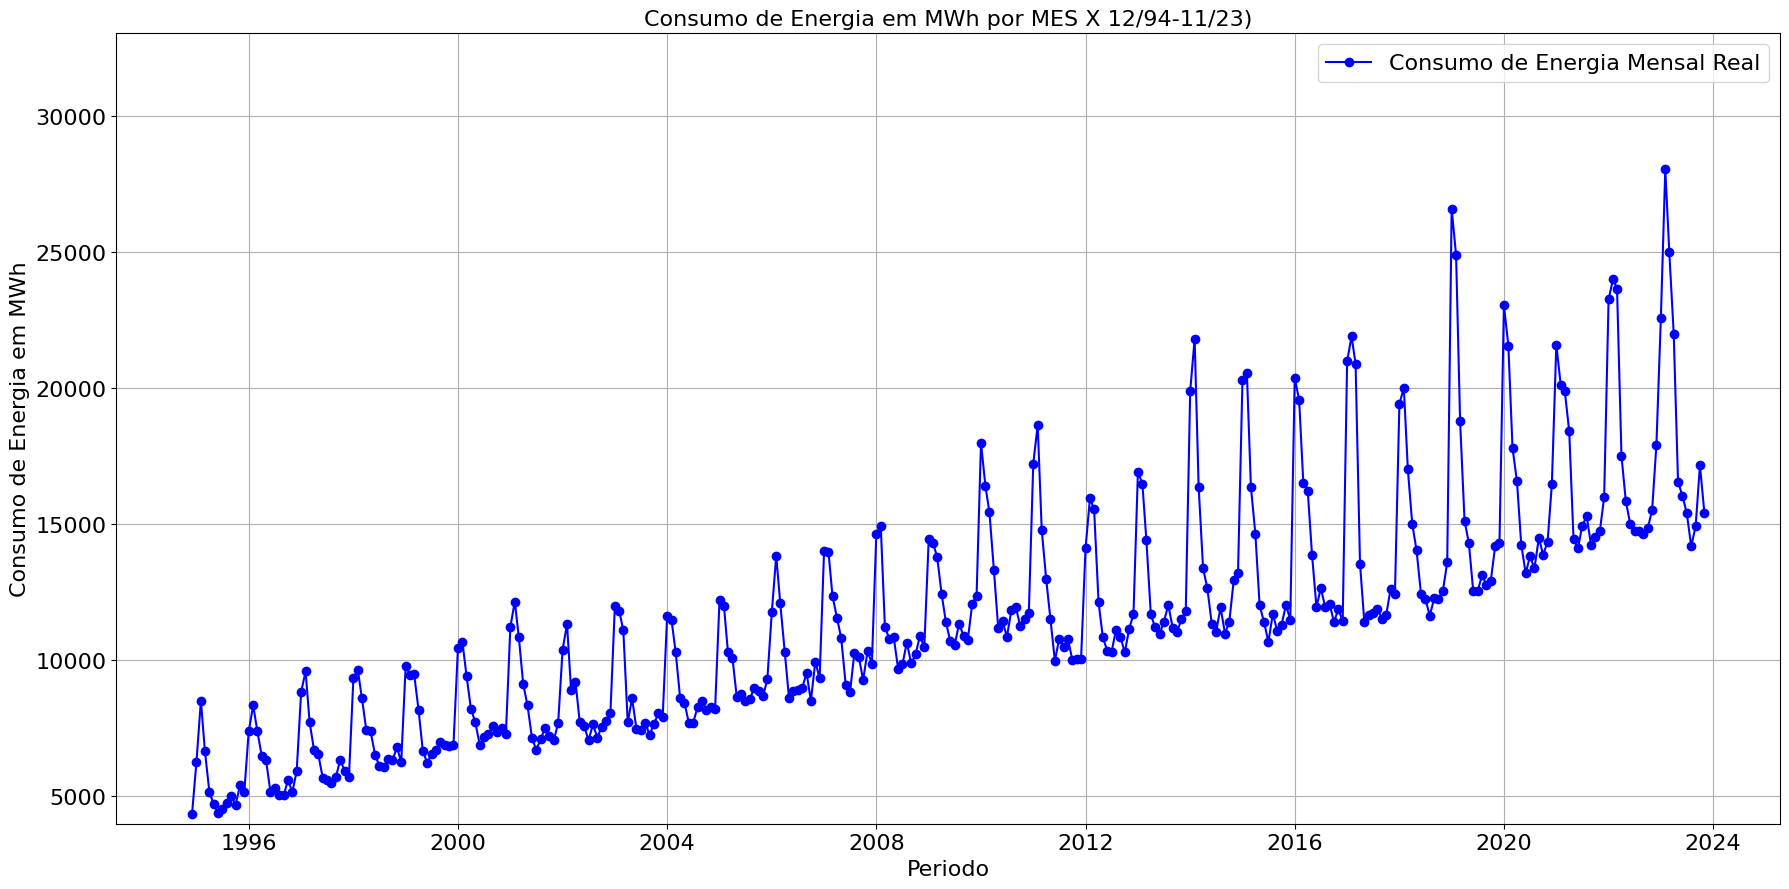

In [9]:
plt.figure(figsize=(18,9))
plt.plot(time_seriesf_residencial.index, time_seriesf_residencial['consumo_mensal'], marker='o', color='blue', label="Consumo de Energia Mensal Real")
plt.xlabel('Periodo', fontsize=16)
plt.ylabel('Consumo de Energia em MWh', fontsize=16)
plt.title("Consumo de Energia em MWh por MES X 12/94-11/23)", fontsize=16)
plt.grid()
plt.legend(fontsize=16)
# plt.xticks(rotation=45)
max_value = max(time_seriesf_residencial['consumo_mensal'])  # Valor máximo da década
plt.ylim(4000, max_value+5000)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

## Recorte de 01/2018 a 12/2023

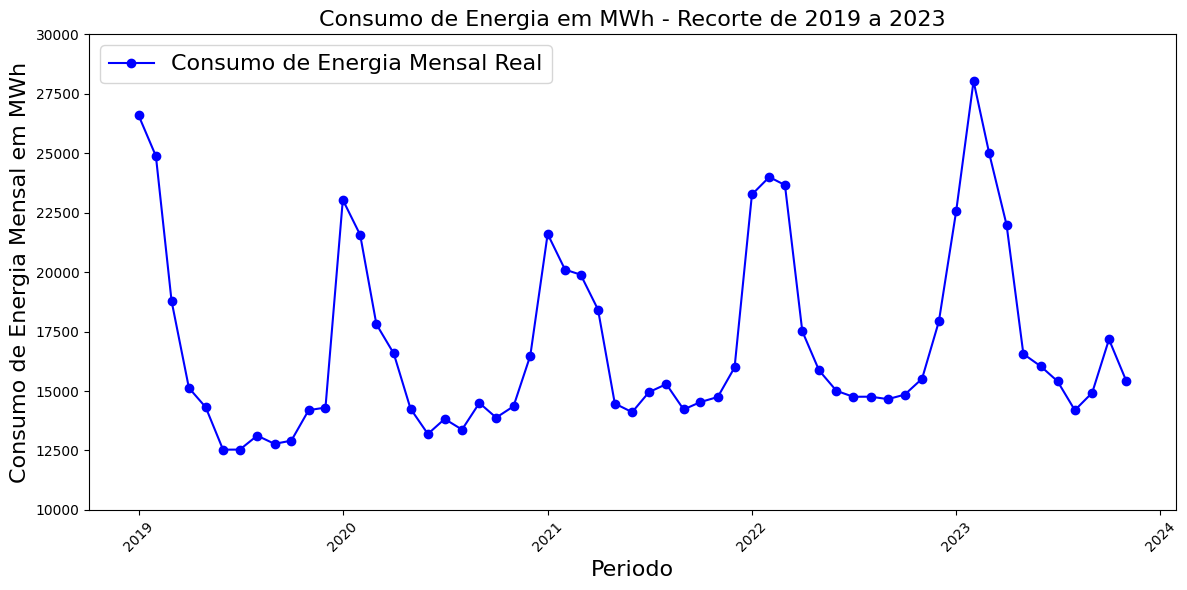

In [ ]:
recorte = (time_seriesf_residencial.index.year > 2018)
plt.figure(figsize=(12, 6))
plt.plot(time_seriesf_residencial[recorte].index, time_seriesf_residencial[recorte]['consumo_mensal'], marker='o', color='blue', label='Consumo de Energia Mensal Real')
plt.xlabel('Periodo', fontsize=16)
plt.ylabel('Consumo de Energia Mensal em MWh', fontsize=16)
plt.title('Consumo de Energia em MWh - Recorte de 2019 a 2023', fontsize=16)
plt.ylim(10000, 30000)
plt.legend(fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

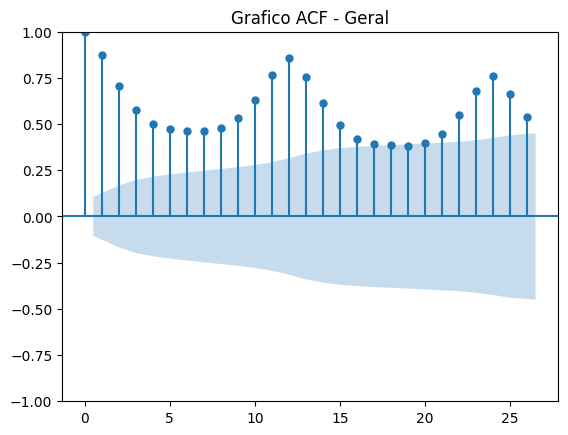

In [ ]:
plot_acf(time_seriesf_residencial.consumo_mensal)
plt.title("Grafico ACF - Geral")
plt.show()

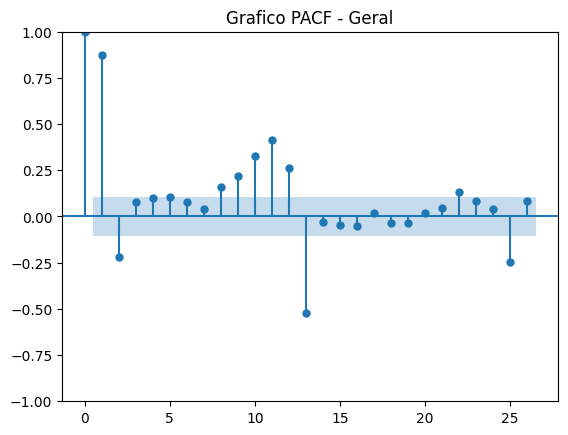

In [ ]:
plot_pacf(time_seriesf_residencial.consumo_mensal)
plt.title("Grafico PACF - Geral")
plt.show()

# Metodo de testar estacionaridade:

In [ ]:
from statsmodels.tsa.stattools import adfuller

def testar_estacionariedade(serie):
    # Teste de Dickey-Fuller Aumentado (ADF)
    resultado_adf = adfuller(serie)
    print("Teste de Dickey-Fuller Aumentado (ADF)")
    print(f"Estatística do teste: {resultado_adf[0]}")
    print(f"Valor-p: {resultado_adf[1]}")
    print(f"Número de lags utilizados: {resultado_adf[2]}")
    print(f"Número de observações utilizadas: {resultado_adf[3]}")
    print("Resultado do teste:")
    if resultado_adf[1] <= 0.05:
        print("A série é estacionária.")
    else:
        print("A série não é estacionária.")

testar_estacionariedade(time_seriesf_residencial['consumo_mensal'])

Teste de Dickey-Fuller Aumentado (ADF)
Estatística do teste: 0.4422241299203933
Valor-p: 0.98300712351057
Número de lags utilizados: 12
Número de observações utilizadas: 335
Resultado do teste:
A série não é estacionária.


## Fazendo a Diferenciação pois a serie não é estacionária (12/94 - 06/23)

In [10]:
time_seriesf_residencial['diff_consumo_mensal'] = time_seriesf_residencial['consumo_mensal'].diff()
time_seriesf_residencial.diff_consumo_mensal[0] = time_seriesf_residencial.diff_consumo_mensal[1]
time_seriesf_residencial.diff_consumo_mensal.head()

index_date
1994-12-01    1920.018
1995-01-01    1920.018
1995-02-01    2250.644
1995-03-01   -1855.158
1995-04-01   -1486.588
Freq: MS, Name: diff_consumo_mensal, dtype: float64

## Realizando o teste de estacionaridade novamente apos o diff

In [11]:
testar_estacionariedade(time_seriesf_residencial['diff_consumo_mensal'])

NameError: name 'testar_estacionariedade' is not defined

## plotando o grafico dos valores com a diferenciação

In [ ]:
# Plotar a série diferenciada
# filtro_outliers = (time_seriesf_residencial.diff_consumo_mensal > 600) | (time_seriesf_residencial.diff_consumo_mensal < -600)
# filtro_outliers

plt.figure(figsize=(12, 6))
plt.plot(time_seriesf_residencial.index, time_seriesf_residencial['diff_consumo_mensal'], marker='o', color='blue', label="Dados Mensais de Consumo de Energia em MWh")
plt.xlabel('Periodo', fontsize=16)
plt.ylabel('Diferenciação do Consumo Mensal', fontsize=16)
plt.title('Série Temporal Diferenciada (Estacionária)', fontsize=16)
plt.tight_layout()

# outliers = time_seriesf_residencial[filtro_outliers].diff_consumo_mensal
# print("outliers", outliers)

# for outlier in outliers.index.tolist():
#     plt.annotate(" <- Outlier", (outlier, time_seriesf_residencial.diff_consumo_mensal.loc[outlier]), color="red", fontsize=16)

plt.show()

### removendo outliers

In [ ]:
outliers_index = time_seriesf_residencial[filtro_outliers].diff_consumo_mensal.index

for outlier in outliers_index:
  previousM = time_seriesf_residencial.loc[outlier - pd.DateOffset(months=1)]
  nextM = time_seriesf_residencial.loc[outlier + pd.DateOffset(months=1)]
  mean_values = (nextM.diff_consumo_mensal + previousM.diff_consumo_mensal)/2
  time_seriesf_residencial.loc[outlier, "diff_consumo_mensal"] = mean_values

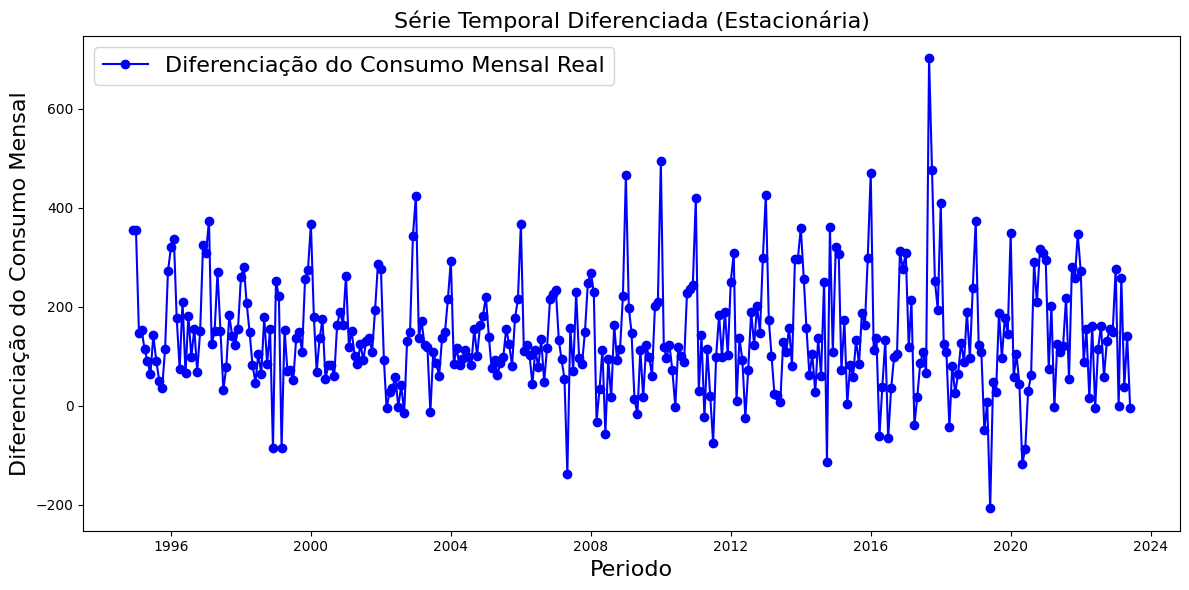

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(time_seriesf_residencial.index, time_seriesf_residencial['diff_consumo_mensal'], marker='o', color='blue', label="Diferenciação do Consumo Mensal Real")
plt.xlabel('Periodo', fontsize=16)
plt.ylabel('Diferenciação do Consumo Mensal', fontsize=16)
plt.title('Série Temporal Diferenciada (Estacionária)', fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

### Plotando ACF - com diferenciação

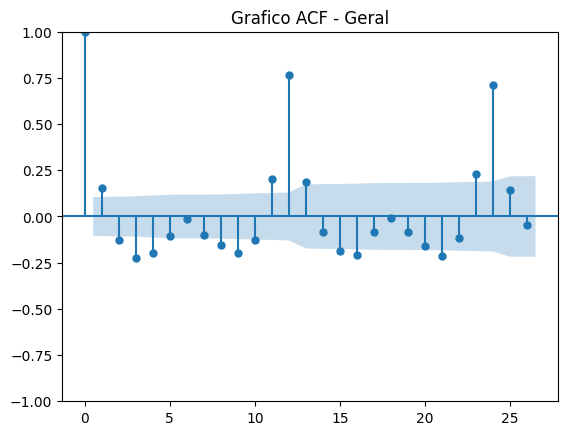

In [ ]:
plot_acf(time_seriesf_residencial.diff_consumo_mensal)
plt.title("Grafico ACF - Geral")
plt.show()

### Plotando PACF - com diferenciação

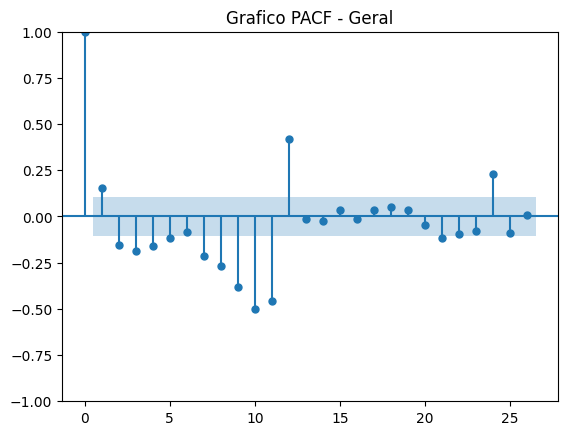

In [ ]:
plot_pacf(time_seriesf_residencial.diff_consumo_mensal)
plt.title("Grafico PACF - Geral")
plt.show()

# Decompor as respectivas séries - Análise exploratória

## verificando sazonalidade

### Scatter Plot - Normas dos Ruídos

I 0 [-0.12635526]
I 1 [-0.01358027]
I 2 [-0.20731494]
I 3 [0.82623901]


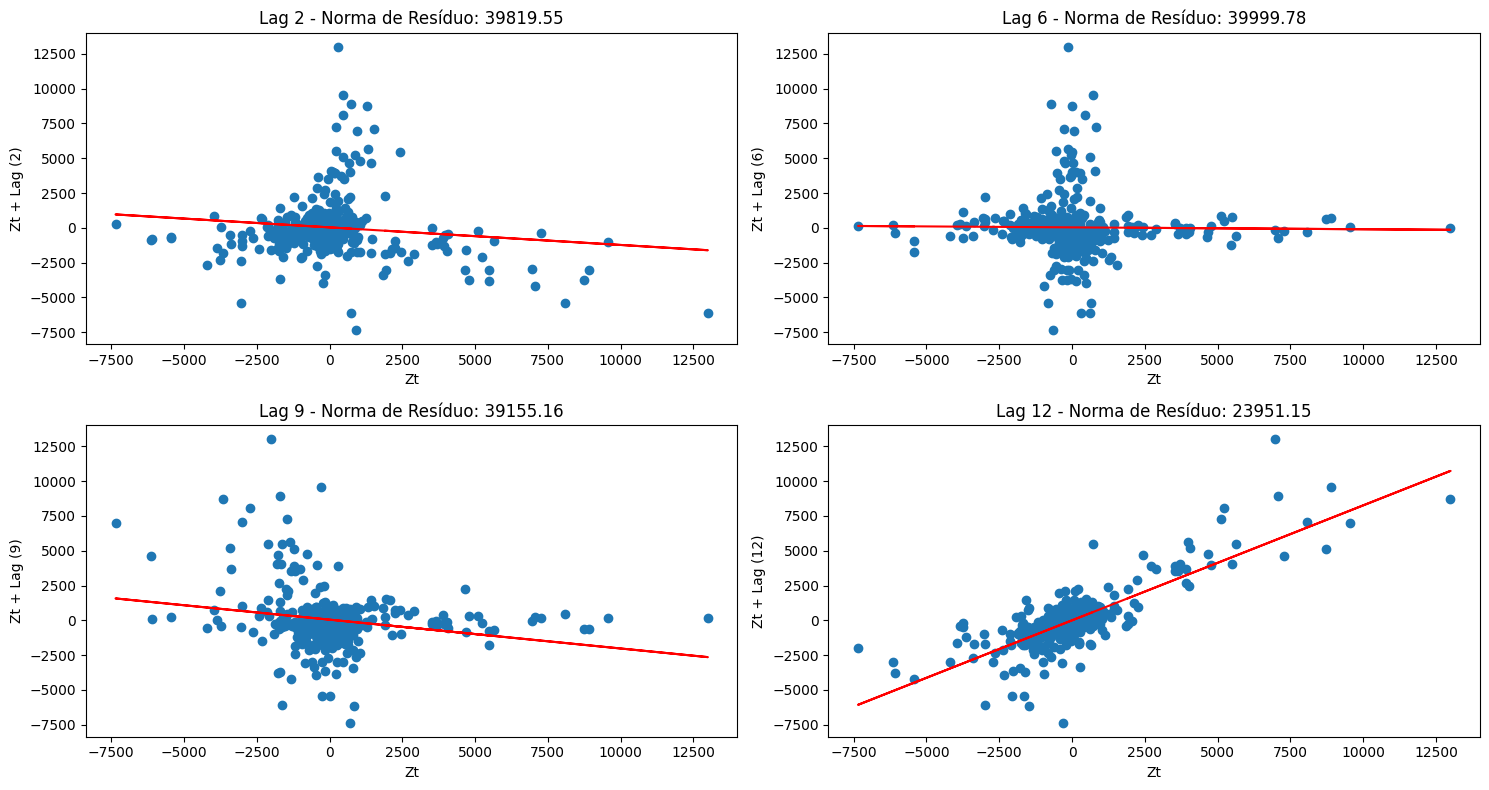

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

intervalos_lag = [2,6,9,12]  #Array de intervalos de lag
normas_residuo = []

fig, axs = plt.subplots(2, 2, figsize=(15, 8))
axs = axs.ravel()

for i, lag in enumerate(intervalos_lag):
    #Aplica os vaores de lag as observações
    x = time_seriesf_residencial['diff_consumo_mensal'].values[:-lag]
    y = time_seriesf_residencial['diff_consumo_mensal'].values[lag:]

    #Faz o fit, input/output
    model.fit(x.reshape(-1,1), y)
    #Realiza a previsão, output com relação aos inputs
    pred = model.predict(x.reshape(-1,1))
    print("I", i, model.coef_)

    #Calcula a norma dos resíduos
    residuos = np.sqrt(np.sum((y - pred) ** 2))
    normas_residuo.append(residuos)

    axs[i].scatter(x, y)
    axs[i].set_xlabel('Zt')
    axs[i].set_ylabel(f'Zt + Lag ({lag})')
    axs[i].set_title(f'Lag {lag} - Norma de Resíduo: {normas_residuo[i]:.2f}')
    axs[i].plot(x, pred, color = 'r')

plt.tight_layout()
plt.show()

I 0 [-0.12635526]
I 1 [-0.01358027]
I 2 [-0.20731494]
I 3 [0.82623901]


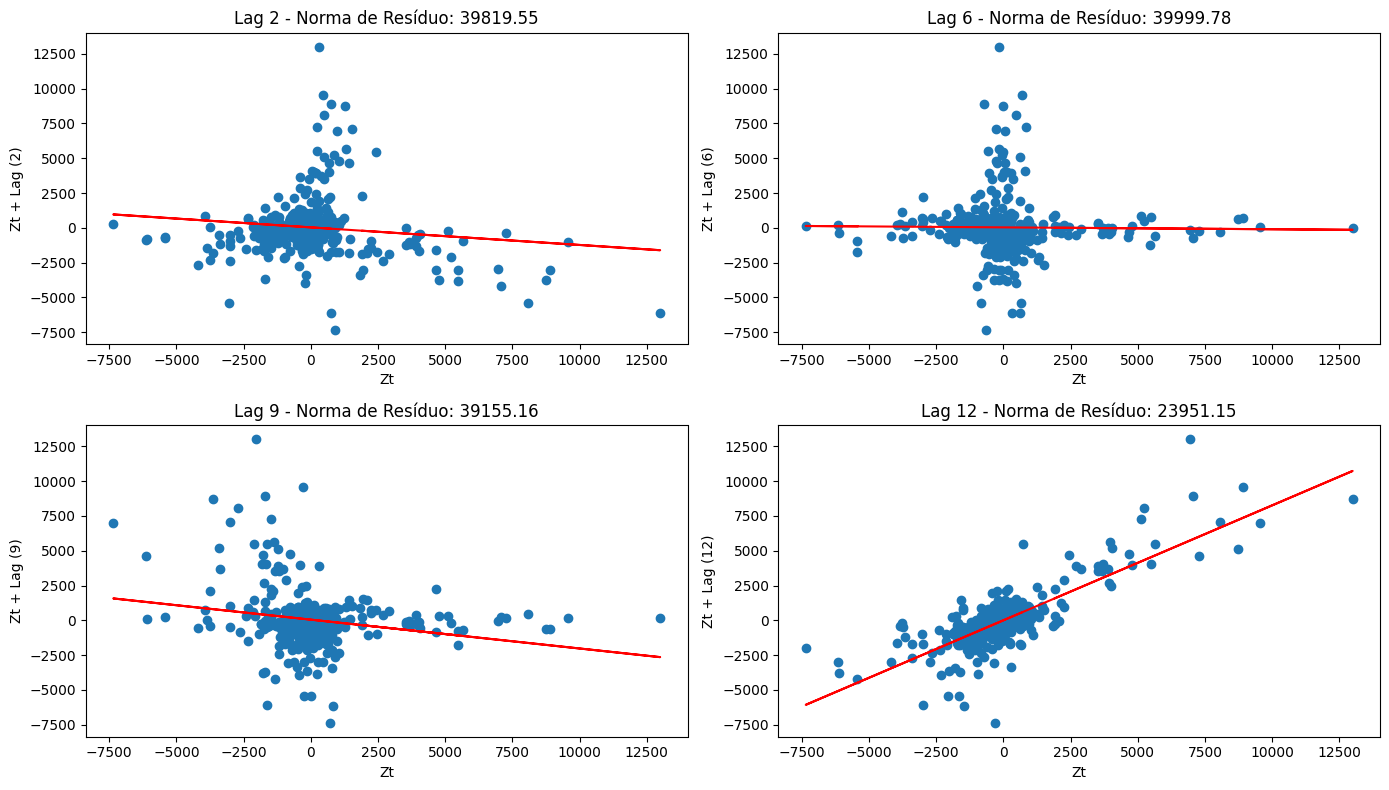

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

intervalos_lag = [2,6,9,12]  #Array de intervalos de lag
normas_residuo = []

fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs = axs.ravel()

for i, lag in enumerate(intervalos_lag):
    #Aplica os vaores de lag as observações
    x = time_seriesf_residencial['diff_consumo_mensal'].values[:-lag]
    y = time_seriesf_residencial['diff_consumo_mensal'].values[lag:]

    #Faz o fit, input/output
    model.fit(x.reshape(-1,1), y)
    #Realiza a previsão, output com relação aos inputs
    pred = model.predict(x.reshape(-1,1))
    print("I", i, model.coef_)

    #Calcula a norma dos resíduos
    residuos = np.sqrt(np.sum((y - pred) ** 2))
    normas_residuo.append(residuos)

    axs[i].scatter(x, y)
    axs[i].set_xlabel('Zt')
    axs[i].set_ylabel(f'Zt + Lag ({lag})')
    axs[i].set_title(f'Lag {lag} - Norma de Resíduo: {normas_residuo[i]:.2f}')
    axs[i].plot(x, pred, color = 'r')

plt.tight_layout()
plt.show()

### Obtendo o valor de Tendencia, M = 12

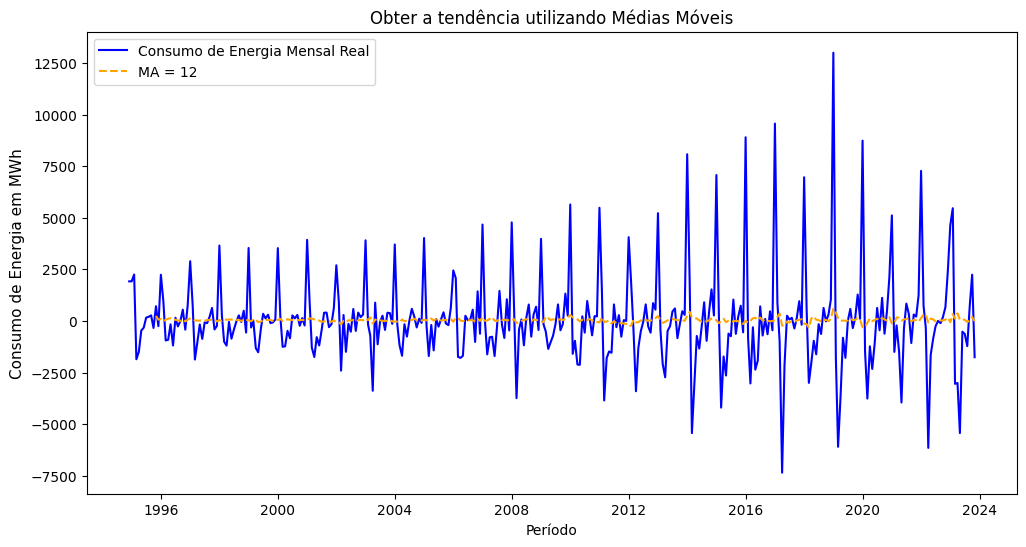

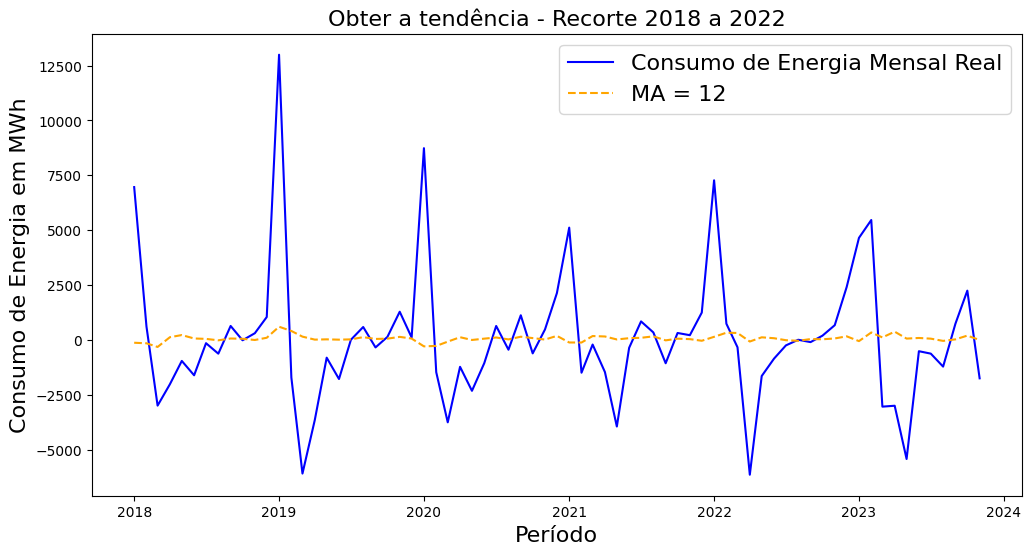

In [ ]:
anual = time_seriesf_residencial.diff_consumo_mensal.rolling(12).mean()
plt.figure(figsize=(12, 6))
plt.plot(time_seriesf_residencial.diff_consumo_mensal, color="blue", label='Consumo de Energia Mensal Real')
plt.plot(anual, color="orange", linestyle="--", label='MA = 12')
plt.title('Obter a tendência utilizando Médias Móveis')
plt.xlabel('Período')
plt.ylabel('Consumo de Energia em MWh', fontsize=11)
plt.legend()
plt.show()

# Aplicando filtro de 2018 a 2022
plt.figure(figsize=(12, 6))
plt.plot(time_seriesf_residencial.diff_consumo_mensal[recorte], color="blue", label='Consumo de Energia Mensal Real')
plt.plot(anual[recorte], color="orange", linestyle="--", label='MA = 12')
plt.title('Obter a tendência - Recorte 2018 a 2022', fontsize=16)
plt.xlabel('Período', fontsize=16)
plt.ylabel('Consumo de Energia em MWh', fontsize=16)
plt.legend(fontsize=16)
plt.show()

### Plot do grafico de sazonalidade

In [ ]:
anual_sazonalidade = pd.DataFrame(time_seriesf_residencial.diff_consumo_mensal)
anual_sazonalidade['indice_sazonal'] = time_seriesf_residencial['diff_consumo_mensal'] - anual
anual_sazonalidade['month'] = time_seriesf_residencial['month']
anual_sazonalidade = anual_sazonalidade.dropna()
anual_sazonalidade

,diff_consumo_mensal,indice_sazonal,month
index_date,,,
1995-11-01,715.621,467.679917,11
1995-12-01,-252.360,-319.269583,12
1996-01-01,2240.312,2146.711250,1
1996-02-01,954.110,968.553750,2
1996-03-01,-943.259,-1004.806833,3
...,...,...,...
2023-07-01,-628.234,-682.832583,7
2023-08-01,-1219.743,-1172.350167,8
2023-09-01,734.549,712.140583,9


In [ ]:
#Separa os índices sazonais em 12 colunas que equivalem aos meses do ano
sazonalidade = anual_sazonalidade.pivot(columns='month', values='indice_sazonal')

#Calcula as médias dos índices sazonais
mean_ad = {}

for i in range(1, 13):
  new_row = sazonalidade[i].mean().round(2)
  mean_ad[i] = new_row

mean_ad = pd.DataFrame(mean_ad, index=[0])
mean_sum = mean_ad.sum(axis=1).sum().round(2)

mean_sea_index_ad = {}
for i in range(1, 13):
   media = float(mean_ad[i]) - (mean_sum / 12).round(2)
   mean_sea_index_ad[i] = media

saz = [mean_sea_index_ad[i % len(mean_sea_index_ad) + 1] for i in range(len(anual_sazonalidade))]
anual_sazonalidade['Sazonalidade_AD'] = saz
anual_sazonalidade

,diff_consumo_mensal,indice_sazonal,month,Sazonalidade_AD
index_date,,,,
1995-11-01,715.621,467.679917,11,5309.81
1995-12-01,-252.360,-319.269583,12,347.92
1996-01-01,2240.312,2146.711250,1,-2091.85
1996-02-01,954.110,968.553750,2,-2064.09
1996-03-01,-943.259,-1004.806833,3,-1350.84
...,...,...,...,...
2023-07-01,-628.234,-682.832583,7,-61.72
2023-08-01,-1219.743,-1172.350167,8,-47.66
2023-09-01,734.549,712.140583,9,378.88


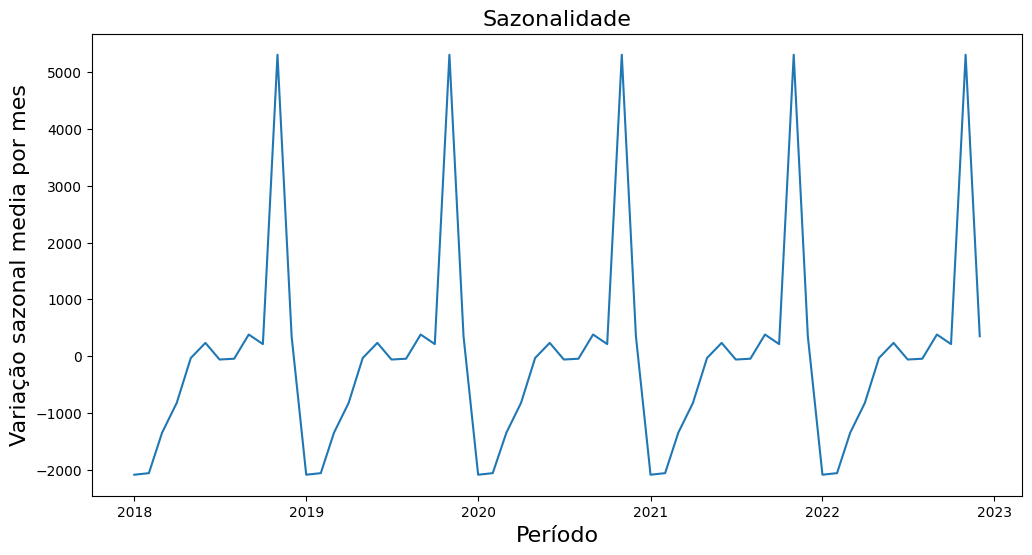

In [ ]:
recorte_anual_sazonalidade = (anual_sazonalidade.index.year > 2017) & (anual_sazonalidade.index.year <= 2022)
plt.figure(figsize=(12, 6))
plt.plot(anual_sazonalidade[recorte_anual_sazonalidade].Sazonalidade_AD)
plt.title('Sazonalidade', fontsize=16)
plt.xlabel('Período', fontsize=16)
plt.ylabel('Variação sazonal media por mes', fontsize=16)
plt.show()

### Residuo

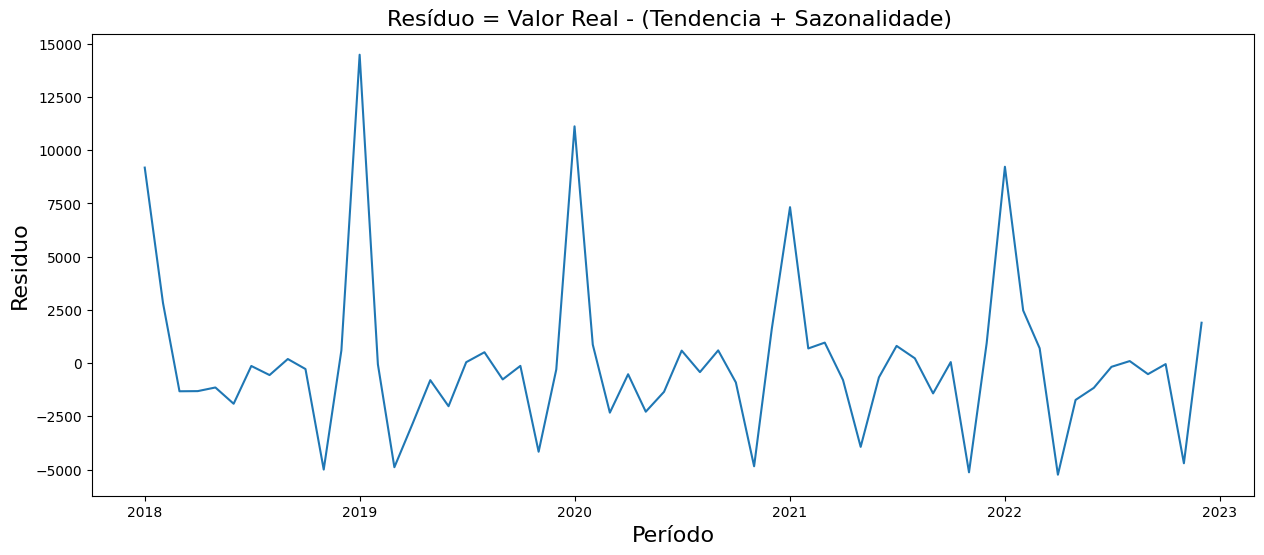

In [ ]:
anual_sazonalidade['Residuo'] = anual_sazonalidade['diff_consumo_mensal'] - (anual + anual_sazonalidade['Sazonalidade_AD'])

plt.figure(figsize=(15, 6))
plt.plot(anual_sazonalidade[recorte_anual_sazonalidade].Residuo)
plt.title('Resíduo = Valor Real - (Tendencia + Sazonalidade) ', fontsize=16)
plt.xlabel('Período', fontsize=16)
plt.ylabel('Residuo', fontsize=16)
plt.show()

# Erro Percentual Absoluto Médio

In [ ]:
def mean_absolute_percentage_error(y_real, y_pred):
    y_real[y_real == 0] = 1e-10
    y_real, y_pred = np.array(y_real), np.array(y_pred)
    return np.mean(np.abs((y_real - y_pred) / y_real)) * 100

# Técnica NAIVE - Inocente (somente dado anterior) lag=1

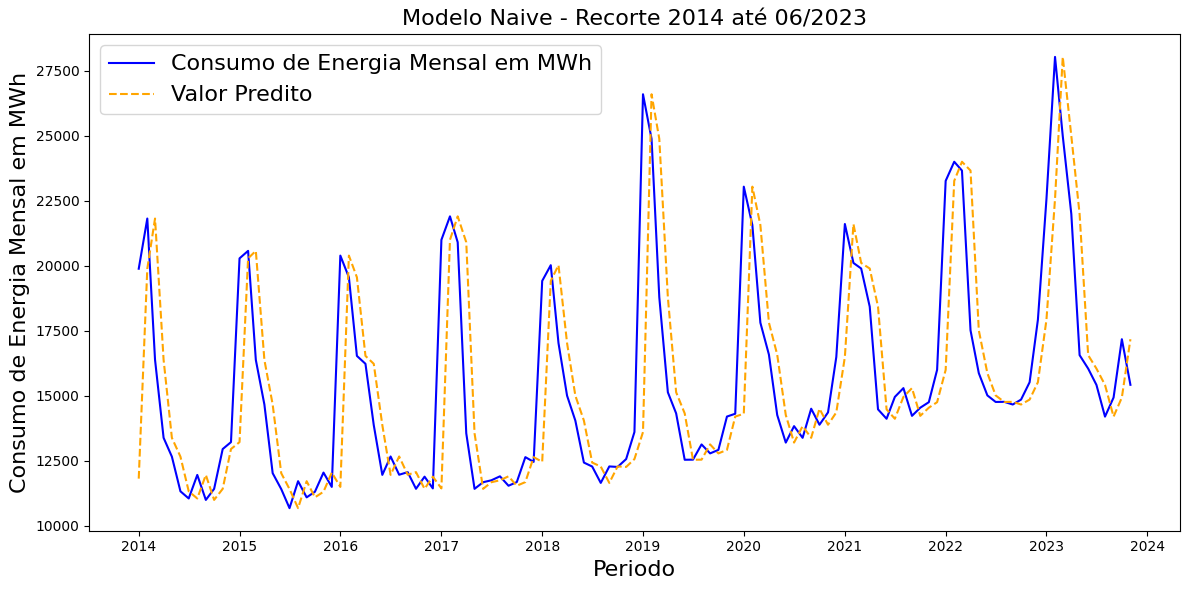

Erro Quadrado Médio (MSE) do Modelo Naive: 4654856.047425744
Coeficiente de Determinação (R-squared) do Modelo Naive: 0.7522871642650164


In [ ]:
# Definir lag para o modelo Naive (lag=1)
lag = 1

time_seriesf_residencial_NAIVE = time_seriesf_residencial.copy()
filtro2 = (time_seriesf_residencial_NAIVE.index.year > 2017) & (time_seriesf_residencial_NAIVE.index.year <= 2022)

# Calcular os lags dos logs
time_seriesf_residencial_NAIVE['log_lag_1'] = time_seriesf_residencial_NAIVE['consumo_mensal'].shift(lag)

# Remover as primeiras linhas que contêm valores nulos
time_seriesf_residencial_NAIVE = time_seriesf_residencial_NAIVE.dropna()

recorte2014 = (time_seriesf_residencial_NAIVE.index.year > 2013)

# Calcular previsões usando o modelo Naive
naive_predictions = time_seriesf_residencial_NAIVE['log_lag_1']

# Calcular resíduos
residuals = time_seriesf_residencial_NAIVE['consumo_mensal'] - naive_predictions

# Calcular métrica de avaliação (por exemplo, Erro Quadrado Médio)
mse = mean_squared_error(time_seriesf_residencial_NAIVE['consumo_mensal'], naive_predictions)
r2 = r2_score(time_seriesf_residencial_NAIVE['consumo_mensal'], naive_predictions)

# Plotar previsões do modelo Naive
plt.figure(figsize=(12, 6))
plt.plot(time_seriesf_residencial_NAIVE[recorte2014].index, time_seriesf_residencial_NAIVE[recorte2014]['consumo_mensal'], label='Consumo de Energia Mensal em MWh', color='blue')
plt.plot(time_seriesf_residencial_NAIVE[recorte2014].index, naive_predictions[recorte2014], linestyle='--', label='Valor Predito', color='orange')
plt.xlabel('Periodo', fontsize=16)
plt.ylabel('Consumo de Energia Mensal em MWh', fontsize=16)
plt.title('Modelo Naive - Recorte 2014 até 06/2023', fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

print(f'Erro Quadrado Médio (MSE) do Modelo Naive: {mse}')
# MSE = 48496.58187134503
print(f'Coeficiente de Determinação (R-squared) do Modelo Naive: {r2}')

In [ ]:
naive_predictions[-1]

17170.48

valor de R-squared negativo, é um indicativo de que o modelo é muito pobre em ajustar os dados

# Suavização Exponencial Simples

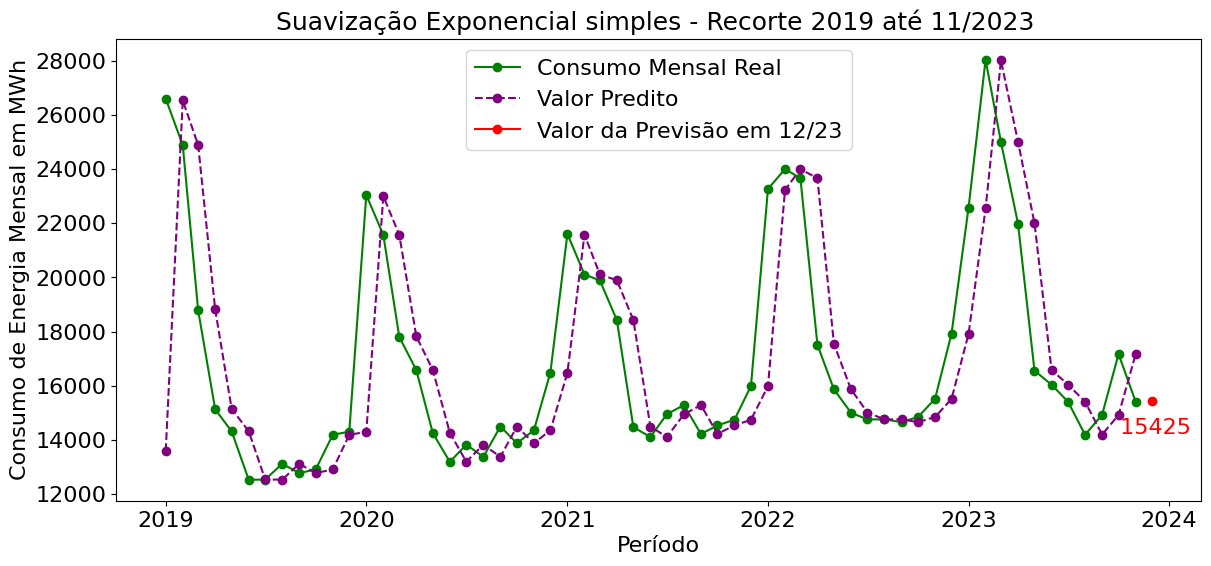

In [15]:
time_seriesf_residencial_suavi_simples = time_seriesf_residencial.copy()

model_suave = sm.tsa.SimpleExpSmoothing(time_seriesf_residencial_suavi_simples.consumo_mensal, initialization_method='estimated').fit()
model_suave_forecast = model_suave.forecast(1)

recorte2014 = (time_seriesf_residencial_suavi_simples.index.year > 2018)
plt.figure(figsize=(14, 6))
plt.plot(time_seriesf_residencial_suavi_simples[recorte2014].consumo_mensal, marker='o', color='green', label='Consumo Mensal Real')
plt.plot(model_suave.fittedvalues[recorte2014], marker='o', color='purple', linestyle="--", label='Valor Predito')
plt.plot(model_suave_forecast, marker='o', color='red', label="Valor da Previsão em 12/23")
plt.title('Suavização Exponencial simples - Recorte 2019 até 11/2023 ', fontsize=18)
plt.xlabel('Período', fontsize=16)
plt.ylabel('Consumo de Energia Mensal em MWh', fontsize=16)
plt.annotate(f" {round(model_suave_forecast[0])}", (model_suave_forecast.index[0], int(model_suave_forecast[0])-600), color="red", fontsize=16, ha='center', va='top')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [ ]:
mse = mean_squared_error(time_seriesf_residencial_suavi_simples['diff_consumo_mensal'], model_suave.fittedvalues)
r2 = r2_score(time_seriesf_residencial_suavi_simples['diff_consumo_mensal'], model_suave.fittedvalues)

# Erro Quadrado Médio (MSE) da Suavização Simples: 48556.27492929763
print(f'Erro Quadrado Médio (MSE) da Suavização Simples: {mse}')
print(f'Coeficiente de Determinação (R-squared) da Suavização Simples: {r2}')

Erro Quadrado Médio (MSE) da Suavização Simples: 159272921.4803989
Coeficiente de Determinação (R-squared) da Suavização Simples: -33.24722405912593


# Suavização de Holt-Winters

                previsao
2023-12-01  18102.811985


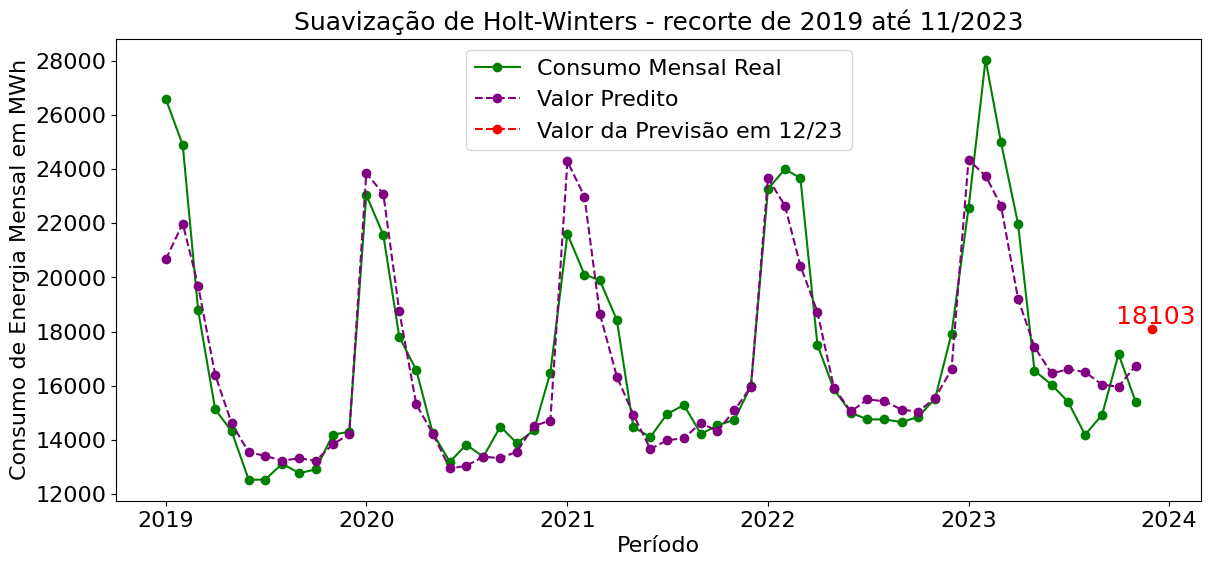

In [17]:
time_seriesf_residencial_holt_simples = time_seriesf_residencial.copy()

model_HW = sm.tsa.ExponentialSmoothing(
    time_seriesf_residencial_holt_simples.consumo_mensal,
    seasonal_periods=12,
    trend="add",
    seasonal='add',
    initialization_method='estimated',
).fit()

# Criar um DataFrame com índice de datas para as previsões
forecast_index = pd.date_range(start=time_seriesf_residencial_holt_simples.index[-1] + pd.DateOffset(days=30), periods=1, freq='MS')

forecast_df = pd.DataFrame(index=forecast_index)
forecast_df
# # Gerar as previsões usando o modelo
forecast_values = model_HW.forecast(1)

# # Adicionar as previsões ao DataFrame de previsões
forecast_df['previsao'] = forecast_values.values

print(forecast_df)

recorte2014 = (time_seriesf_residencial_holt_simples.index.year > 2018)
# Plotar os dados originais e as previsões
plt.figure(figsize=(14, 6))
plt.plot(time_seriesf_residencial_holt_simples[recorte2014].consumo_mensal, marker='o', color='green', label='Consumo Mensal Real')
plt.plot(model_HW.fittedvalues[recorte2014], linestyle="--", marker='o', color='purple', label='Valor Predito')
plt.plot(forecast_df['previsao'], linestyle="--", marker='o', color='red', label='Valor da Previsão em 12/23')
plt.title('Suavização de Holt-Winters - recorte de 2019 até 11/2023', fontsize=18)
plt.xlabel('Período', fontsize=16)
plt.ylabel('Consumo de Energia Mensal em MWh', fontsize=16)
plt.annotate(f" {round(forecast_df['previsao'][0])}", (forecast_df.index[0], forecast_df['previsao'][0]), color="red", fontsize=18, ha='center', va='bottom')
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [ ]:
mse = mean_squared_error(time_seriesf_residencial_holt_simples['diff_consumo_mensal'], model_HW.fittedvalues)
r2 = r2_score(time_seriesf_residencial_holt_simples['diff_consumo_mensal'], model_HW.fittedvalues)

# Erro Quadrado Médio (MSE) da Suavização Holt: 29261.986562576032
print(f'Erro Quadrado Médio (MSE) da Suavização Holt: {mse}')
print(f'Coeficiente de Determinação (R-squared) da Suavização Holt: {r2}')

Erro Quadrado Médio (MSE) da Suavização Holt: 149969022.69941908
Coeficiente de Determinação (R-squared) da Suavização Holt: -31.246678685725108


# ARIMA MODEL

## Dividir os Dados em Treinamento (70%) e Teste (30%)

In [ ]:
time_seriesf_residencial_arima = time_seriesf_residencial.copy()

# Dividir os dados em treinamento e teste
train_size = int(len(time_seriesf_residencial_arima) * 0.7)
print("quantidade de treino:", train_size)
print("quantidade de teste:", len(time_seriesf_residencial_arima) - train_size)

time_seriesf_residencial_arima['date'] = pd.to_datetime(time_seriesf_residencial_arima['date'])
time_seriesf_residencial_arima.set_index('date', inplace=True)
time_seriesf_residencial_arima = time_seriesf_residencial_arima.asfreq('MS')
time_seriesf_residencial_arima

time_seriesf_residencial_arima_train = time_seriesf_residencial_arima[:train_size]
time_seriesf_residencial_arima_test = time_seriesf_residencial_arima[train_size:]
time_seriesf_residencial_arima_test.head()

quantidade de treino: 243
quantidade de teste: 105


,consumo_mensal,month
date,,
2015-03-01,16374.983,3
2015-04-01,14657.350,4
2015-05-01,12016.341,5
2015-06-01,11405.417,6
2015-07-01,10670.310,7


## ARIMA - SEM OTIMIZAÇÃO

### Grid Search com AIC

O valor do AIC é uma medida de qualidade do ajuste do modelo aos dados, e um valor menor indica um ajuste melhor (menos sobreajuste). Escolher a que resultar em um menor valor de AIC.

In [ ]:
# Definindo os valores para p, d e q que você deseja testar
p_values = [1,2,3,4,6,9,12]  # De 1 a 12
d_values = range(0, 3)  # De 0 a 2
q_values = [1,2,3,4,6,9,12]  # De 1 a 12

best_aic = float('inf')
best_order_aic = None

# Loop para testar todas as combinações de hiperparâmetros
for p in p_values:
  for d in d_values:
    for q in q_values:
      order = (p, d, q)
      print("Grid Search, Order: ",p,d,q)
      model_grid_arima = sm.tsa.ARIMA(time_seriesf_residencial_arima_train.consumo_mensal, order=order, enforce_stationarity=False)
      model_grid_arima = model_grid_arima.fit()
      aic = model_grid_arima.aic
      print("aic: ", aic)
      if aic < best_aic:
        best_aic = aic
        best_order_aic = order
print("Melhor ordem ARIMA:", best_order_aic)

Grid Search, Order:  1 0 1
aic:  4239.926922708099
Grid Search, Order:  1 0 2
aic:  4224.271744135659
Grid Search, Order:  1 0 3
aic:  4186.816517873978
Grid Search, Order:  1 0 4
aic:  4163.803792754054
Grid Search, Order:  1 0 6
aic:  4115.767867863427
Grid Search, Order:  1 0 9
aic:  4060.035505835801
Grid Search, Order:  1 0 12
aic:  3967.090698161959
Grid Search, Order:  1 1 1
aic:  4238.623423756572
Grid Search, Order:  1 1 2
aic:  4183.412560622564
Grid Search, Order:  1 1 3
aic:  4163.337353164365
Grid Search, Order:  1 1 4
aic:  4144.76630907923
Grid Search, Order:  1 1 6
aic:  4089.6882837359067
Grid Search, Order:  1 1 9
aic:  4024.5970864915116
Grid Search, Order:  1 1 12
aic:  3944.022496147471
Grid Search, Order:  1 2 1
aic:  4228.7496690786575
Grid Search, Order:  1 2 2
aic:  4209.813341902805
Grid Search, Order:  1 2 3
aic:  4148.517121413361
Grid Search, Order:  1 2 4
aic:  4146.258790267193
Grid Search, Order:  1 2 6
aic:  4103.746928630295
Grid Search, Order:  1 2 9


### Usando a melhor order do grid search

In [ ]:
model_arima_aic = sm.tsa.ARIMA(time_seriesf_residencial_arima_train.consumo_mensal, order=(12,1,12))
model_arima_aic = model_arima_aic.fit()

model_arima_aic_test = sm.tsa.ARIMA(time_seriesf_residencial_arima_test.consumo_mensal, order=(12,1,12))
with model_arima_aic_test.fix_params(model_arima_aic.params):
        model_arima_aic_test = model_arima_aic_test.fit()

predictions_arima_aic = model_arima_aic.predict()
predictions_arima_aic_test = model_arima_aic_test.predict()
forecast_arima_aic = model_arima_aic_test.forecast()
forecast_arima_aic

2023-12-01    18098.689613
Freq: MS, dtype: float64

In [ ]:
forecast_arima_aic.index[0]
forecast_arima_aic[0]

18098.689612803675

In [ ]:
time_seriesf_residencial_arima_test

,consumo_mensal,month
date,,
2015-03-01,16374.983,3
2015-04-01,14657.350,4
2015-05-01,12016.341,5
2015-06-01,11405.417,6
2015-07-01,10670.310,7
...,...,...
2023-07-01,15412.302,7
2023-08-01,14192.559,8
2023-09-01,14927.108,9


In [ ]:
predictions_arima_aic

date
1994-12-01        0.000000
1995-01-01     5295.953177
1995-02-01     6266.701809
1995-03-01     8781.749221
1995-04-01     5086.839958
                  ...     
2014-10-01    10957.621886
2014-11-01    12208.692960
2014-12-01    14113.141538
2015-01-01    18973.633985
2015-02-01    19547.971494
Freq: MS, Name: predicted_mean, Length: 243, dtype: float64

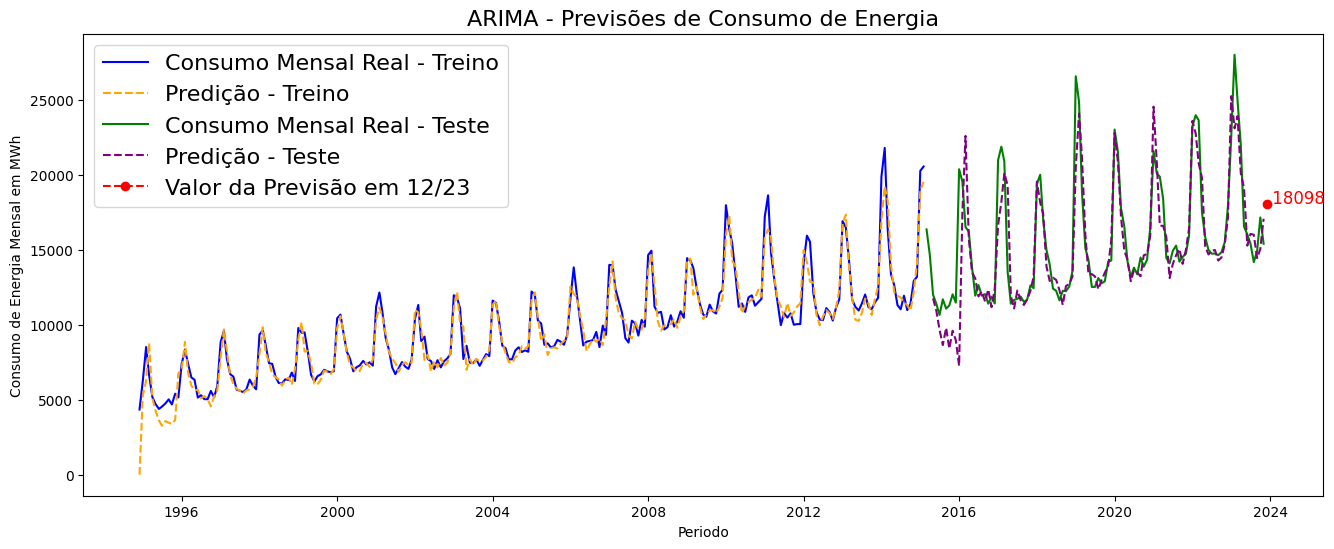

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(time_seriesf_residencial_arima_train.index, time_seriesf_residencial_arima_train['consumo_mensal'], color="blue", label='Consumo Mensal Real - Treino')
plt.plot(time_seriesf_residencial_arima_train.index, predictions_arima_aic, color="orange", linestyle="--",  label='Predição - Treino')
plt.plot(time_seriesf_residencial_arima_test.index, time_seriesf_residencial_arima_test['consumo_mensal'], color="green", label='Consumo Mensal Real - Teste')
plt.plot(time_seriesf_residencial_arima_test.iloc[2:].index, predictions_arima_aic_test.iloc[2:], color="purple", linestyle="--", label='Predição - Teste')
plt.plot(forecast_arima_aic, linestyle="--", marker='o', color='red', label='Valor da Previsão em 12/23')
plt.annotate(f" {int(forecast_arima_aic[0])}", (forecast_arima_aic.index[0], forecast_arima_aic[0]), color="red", fontsize=12)
# plt.ylim(2300, 30000)
plt.legend(fontsize=16)
plt.title('ARIMA - Previsões de Consumo de Energia', fontsize=16)
plt.xlabel('Periodo')
plt.ylabel('Consumo de Energia Mensal em MWh')

# plt.annotate("o", (time_seriesf_residencial_arima_train.iloc[:2].index[0], 30500), color="black", fontsize=16)
# plt.annotate("o", (time_seriesf_residencial_arima_train.iloc[:2].index[1], 55000), color="black", fontsize=16)
# plt.annotate("o", (time_seriesf_residencial_arima_test.iloc[:2].index[0], 30500), color="black", fontsize=16)
# plt.annotate("o", (time_seriesf_residencial_arima_test.iloc[:2].index[1], 75000), color="black", fontsize=16)
plt.show()

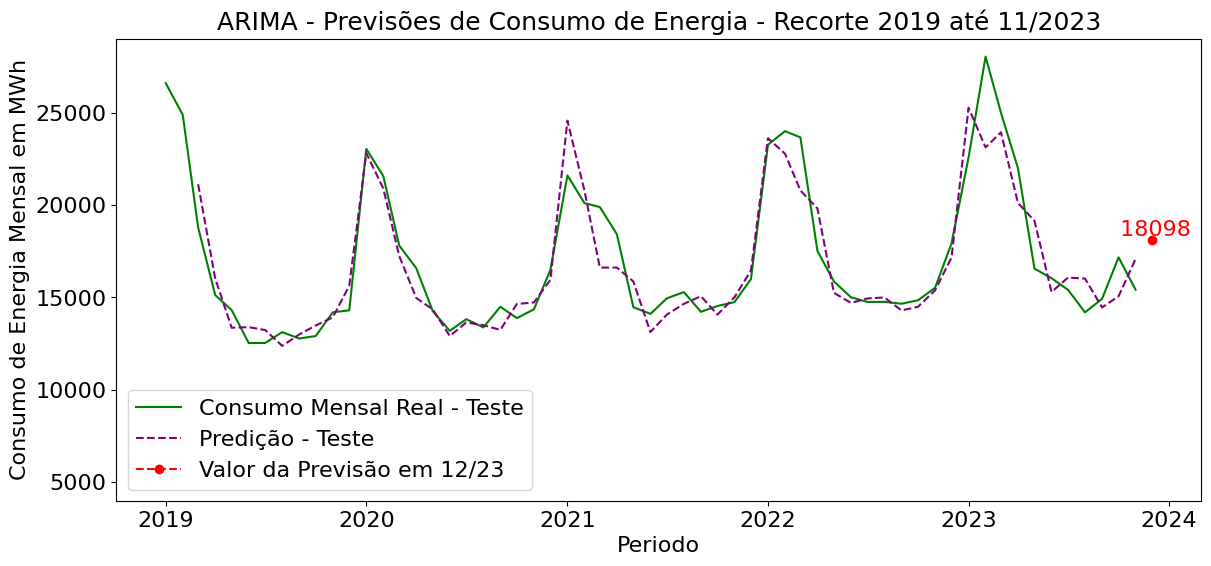

In [ ]:
recorte2019 = (time_seriesf_residencial_arima_train.index.year > 2018)
recorte2019_2 = (time_seriesf_residencial_arima_test.index.year > 2018)
plt.figure(figsize=(14, 6))
# plt.plot(time_seriesf_residencial_arima_train[recorte2019].index, time_seriesf_residencial_arima_train[recorte2019]['consumo_mensal'], color="blue", label='Consumo Mensal Real - Treino')
# plt.plot(time_seriesf_residencial_arima_train[recorte2019].index, predictions_arima_aic[recorte2019], color="orange", linestyle="--",  label='Predição - Treino')
plt.plot(time_seriesf_residencial_arima_test[recorte2019_2].index, time_seriesf_residencial_arima_test[recorte2019_2]['consumo_mensal'], color="green", label='Consumo Mensal Real - Teste')
plt.plot(time_seriesf_residencial_arima_test[recorte2019_2].iloc[2:].index, predictions_arima_aic_test[recorte2019_2].iloc[2:], color="purple", linestyle="--", label='Predição - Teste')
plt.plot(forecast_arima_aic, linestyle="--", marker='o', color='red', label='Valor da Previsão em 12/23')
plt.annotate(f" {int(forecast_arima_aic[0])}", (forecast_arima_aic.index[0], forecast_arima_aic[0]), color="red", fontsize=16, ha='center', va='bottom')
plt.ylim(4000, 29000)
plt.legend(fontsize=16)
plt.title('ARIMA - Previsões de Consumo de Energia - Recorte 2019 até 11/2023', fontsize=18)
plt.xlabel('Periodo', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Consumo de Energia Mensal em MWh', fontsize=16)

# plt.annotate("o", (time_seriesf_residencial_arima_test.iloc[:2].index[0], 60500), color="black", fontsize=16)
# plt.annotate("o", (time_seriesf_residencial_arima_test.iloc[:2].index[1], 71900), color="black", fontsize=16)
plt.show()

### Metrica de Qualidade

In [ ]:
# mape = mean_absolute_percentage_error(time_seriesf_residencial_arima_test['consumo_mensal'].iloc[2:], predictions_arima_aic_test.iloc[2:])
# print(f"MAPE: {mape:.2f}%")

mse = mean_squared_error(time_seriesf_residencial_arima_test['consumo_mensal'].iloc[2:], predictions_arima_aic_test.iloc[2:])
print(f"MSE: {mse:.2f}")

r2 = r2_score(time_seriesf_residencial_arima_test['consumo_mensal'].iloc[2:], predictions_arima_aic_test.iloc[2:])
print("R2: ", r2)

MSE: 4688039.30
R2:  0.7018487037995391


### Grafico ACF e PACF do Residuo apos Arima

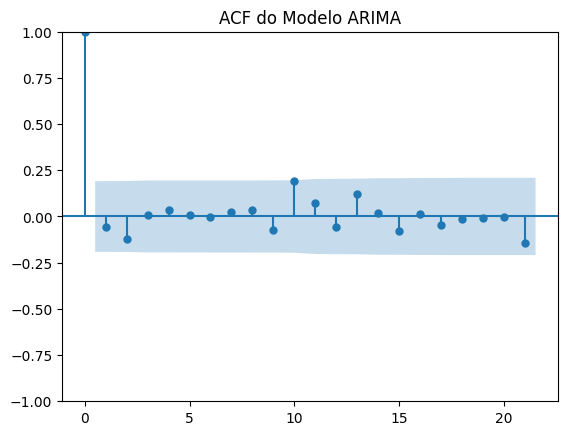

In [ ]:
plot_acf(model_arima_aic_test.resid)
plt.title("ACF do Modelo ARIMA")
plt.show()

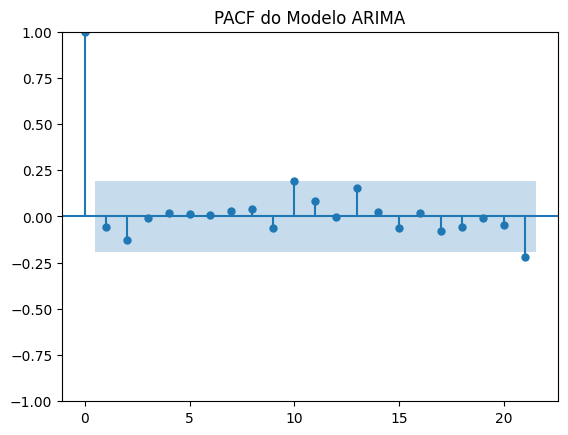

In [ ]:
plot_pacf(model_arima_aic_test.resid)
plt.title("PACF do Modelo ARIMA")
plt.show()

## ARIMA COM OTIMIZAÇÃO

In [ ]:
pip install scipy

In [ ]:
train_data = time_seriesf_residencial_arima_train.consumo_mensal
test_data =  time_seriesf_residencial_arima_test.consumo_mensal

In [ ]:
def arima_model(params, *args):
    train_data, test_data = args
    p, d, q = params
    order = (int(p), int(d), int(q))

    # Cria o modelo SARIMA
    model = sm.tsa.ARIMA(train_data, order=order, enforce_stationarity=False)

    # Treina o modelo
    results = model.fit()

    # Faz previsões no conjunto de teste
    predictions = results.forecast(steps=len(test_data))
    print("Essas são as previsões", predictions)

    aic = results.aic
    print("Esse é o aic:", aic)
    print("Essas são as ordens:", order)

    return aic

In [ ]:
from scipy.optimize import differential_evolution

param_bounds = [(1, 6), (1, 2), (1, 6)]

result = differential_evolution(arima_model, param_bounds, args=(train_data, test_data), maxiter=100)

optimal_rmse = result.fun
print("AIC correspondente aos parametros otimizados:", optimal_rmse)

results_list = [(tuple(result.x), arima_model(result.x, train_data, test_data))]

sorted_results = sorted(results_list, key=lambda x: x[1])

print("parametros otimizados e AIC (ordenados):")
for params, rmse in sorted_results:
    print(f"Parametros: {params}, AIC: {rmse}")

Essas são as previsões 2014-12-01    64694.446454
2015-01-01    64851.265824
2015-02-01    64924.300521
2015-03-01    65045.752509
2015-04-01    65135.700719
                  ...     
2023-02-01    73383.617320
2023-03-01    73462.327794
2023-04-01    73540.862328
2023-05-01    73619.218640
2023-06-01    73697.399692
Freq: MS, Name: predicted_mean, Length: 103, dtype: float64
Esse é o aic: 3043.717701771011
Essas são as ordens: (3, 1, 5)
Essas são as previsões 2014-12-01    64718.343478
2015-01-01    64873.912230
2015-02-01    64943.759754
2015-03-01    65090.136957
2015-04-01    65164.870714
                  ...     
2023-02-01    73932.431451
2023-03-01    74017.279787
2023-04-01    74101.963173
2023-05-01    74186.481929
2023-06-01    74270.836379
Freq: MS, Name: predicted_mean, Length: 103, dtype: float64
Esse é o aic: 3048.5142842290834
Essas são as ordens: (5, 1, 5)
Essas são as previsões 2014-12-01    64736.359003
2015-01-01    64891.032471
2015-02-01    64979.866146
2015-03-0

# SARIMA MODEL

## Dividir os dados em treinamento e teste

In [ ]:
time_seriesf_residencial_sarima = time_seriesf_residencial.copy()

# Dividir os dados em treinamento e teste
train_size = int(len(time_seriesf_residencial_sarima) * 0.7)
print("quantidade de treino:", train_size)
print("quantidade de teste:", len(time_seriesf_residencial_sarima) - train_size)

time_seriesf_residencial_sarima['date'] = pd.to_datetime(time_seriesf_residencial_sarima['date'])
time_seriesf_residencial_sarima.set_index('date', inplace=True)
time_seriesf_residencial_sarima = time_seriesf_residencial_sarima.asfreq('MS')
time_seriesf_residencial_sarima

time_seriesf_residencial_sarima_train = time_seriesf_residencial_sarima[:train_size]
time_seriesf_residencial_sarima_test = time_seriesf_residencial_sarima[train_size:]
time_seriesf_residencial_sarima_test.head()

quantidade de treino: 243
quantidade de teste: 105


,consumo_mensal,month
date,,
2015-03-01,16374.983,3
2015-04-01,14657.350,4
2015-05-01,12016.341,5
2015-06-01,11405.417,6
2015-07-01,10670.310,7


## Grid Search com AIC

In [ ]:
import itertools

p = q = [9,12]
d = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

best_aic = np.inf
best_order = None
best_seasonal_order = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
            model_grid_sarima = sm.tsa.statespace.SARIMAX(time_seriesf_residencial_sarima_train.consumo_mensal,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = model_grid_sarima.fit()

            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = param_seasonal

print(f"Melhor configuração de SARIMA: (p,d,q) = {best_order}, (P,D,Q,s) = {best_seasonal_order}")

In [ ]:
p_values = [1,2,9]
d_values = range(0, 3)
q_values = [1,2,9]
P_values = [1,2,9]
D_values = range(0, 3)
Q_values = [1,2,9]
s = 12
results_sarima = []

best_sarima_aic = 0
best_sarima_order_aic = None

for p in p_values:
  for d in d_values:
    for q in q_values:
      for P in P_values:
        for D in D_values:
          for Q in Q_values:
            order = (p, d, q, P, D, Q, s)
            print("Grid Search Sarima, Order: (",p,d,q,")", "seasonal_order=(",P, D, Q, s,")")
            if(q >= s):
              # as medias moveis que é o q não pode ser igual ou maior que o s que é periocidade
              print("Pula devido ao esse erro: Invalid model: moving average lag(s) {",q,"} are in both the seasonal and non-seasonal moving average components.")
              continue
            if(p >= s):
              # o lag autoregresso que é o p não pode ser igual ou maior que o s que é periocidade
              print("Pula devido ao esse erro: Invalid model: autoregressive lag(s) {",p,"} are in both the seasonal and non-seasonal autoregressive components.")
              continue
            model_grid_sarima = sm.tsa.SARIMAX(time_seriesf_residencial_sarima_train.consumo_mensal, order=(p, d, q), seasonal_order=(P, D, Q, s), enforce_stationarity=False, enforce_invertibility=False)
            model_grid_sarima = model_grid_sarima.fit()
            aic = model_grid_sarima.aic
            print("aic: ", aic)
            if aic < best_sarima_aic:
              best_sarima_aic = aic
              best_sarima_order_aic = order

print("Melhor ordem SARIMA:", best_sarima_order_aic)

Grid Search Sarima, Order: ( 1 0 1 ) seasonal_order=( 1 0 1 12 )
aic:  3641.4673017831406
Grid Search Sarima, Order: ( 1 0 1 ) seasonal_order=( 1 0 2 12 )
aic:  3462.560343025972
Grid Search Sarima, Order: ( 1 0 1 ) seasonal_order=( 1 0 9 12 )
aic:  2267.6800168100954
Grid Search Sarima, Order: ( 1 0 1 ) seasonal_order=( 1 1 1 12 )
aic:  3496.4785542693066
Grid Search Sarima, Order: ( 1 0 1 ) seasonal_order=( 1 1 2 12 )
aic:  3310.317303042919
Grid Search Sarima, Order: ( 1 0 1 ) seasonal_order=( 1 1 9 12 )
aic:  1979.9366164080839
Grid Search Sarima, Order: ( 1 0 1 ) seasonal_order=( 1 2 1 12 )
aic:  3358.3289517488693
Grid Search Sarima, Order: ( 1 0 1 ) seasonal_order=( 1 2 2 12 )
aic:  3128.961937654706
Grid Search Sarima, Order: ( 1 0 1 ) seasonal_order=( 1 2 9 12 )
aic:  1844.7588326324196
Grid Search Sarima, Order: ( 1 0 1 ) seasonal_order=( 2 0 1 12 )
aic:  3475.2765942748333
Grid Search Sarima, Order: ( 1 0 1 ) seasonal_order=( 2 0 2 12 )
aic:  3540.2408745713747
Grid Search S

KeyboardInterrupt: 

In [ ]:
print(best_sarima_order_aic)


None


## model

In [ ]:
# Grid Search Sarima, Order: ( 2 1 1 ) seasonal_order=( 2 2 2 12 )
# aic:  3106.73838253917

# (2,2,9)(9,2,2,12)
# MSE: 32288808.88
# R2:  -1.3265210823498084

# ARIMA (9, 2, 12)
# order=(2, 2, 4), seasonal_order=(9, 0, 12, 12)
# order=(2, 1, 1), seasonal_order=(2, 2, 2, 12))
# Grid Search Sarima, Order: ( 1 1 1 ) seasonal_order=( 2 2 2 12 )
# aic:  3104.8302060038814
# Grid Search Sarima, Order: ( 1 0 1 ) seasonal_order=( 1 0 9 12 )
# aic:  2267.6800168100954
# Grid Search Sarima, Order: ( 1 0 1 ) seasonal_order=( 2 2 9 12 )
# aic:  1845.270206332896
# Grid Search Sarima, Order: ( 1 0 1 ) seasonal_order=( 9 2 1 12 )
# aic:  1855.1903097976665
# Grid Search Sarima, Order: ( 1 0 1 ) seasonal_order=( 2 2 9 12 )
# aic:  1845.270206332896
# Grid Search Sarima, Order: ( 1 0 1 ) seasonal_order=( 1 2 9 12 )
# aic:  1844.7588326324196

sarima = sm.tsa.SARIMAX(time_seriesf_residencial_sarima_train.consumo_mensal, order=(1, 0, 1), seasonal_order=(2, 2, 9, 12), enforce_stationarity=False, enforce_invertibility=False)
sarima = sarima.fit()

sarima_test = sm.tsa.SARIMAX(time_seriesf_residencial_sarima_test.consumo_mensal, order=(1, 0, 1), seasonal_order=(2, 2, 9, 12), enforce_stationarity=False, enforce_invertibility=False)
with sarima_test.fix_params(sarima.params):
        sarima_test = sarima_test.fit()

predictions_sarima_aic = sarima.predict()
predictions_sarima_aic_test = sarima_test.predict()
forecast_sarima_aic = sarima_test.forecast()
forecast_sarima_aic

2023-12-01    19051.762907
Freq: MS, dtype: float64

In [ ]:
sarima.aic

1845.270206332896

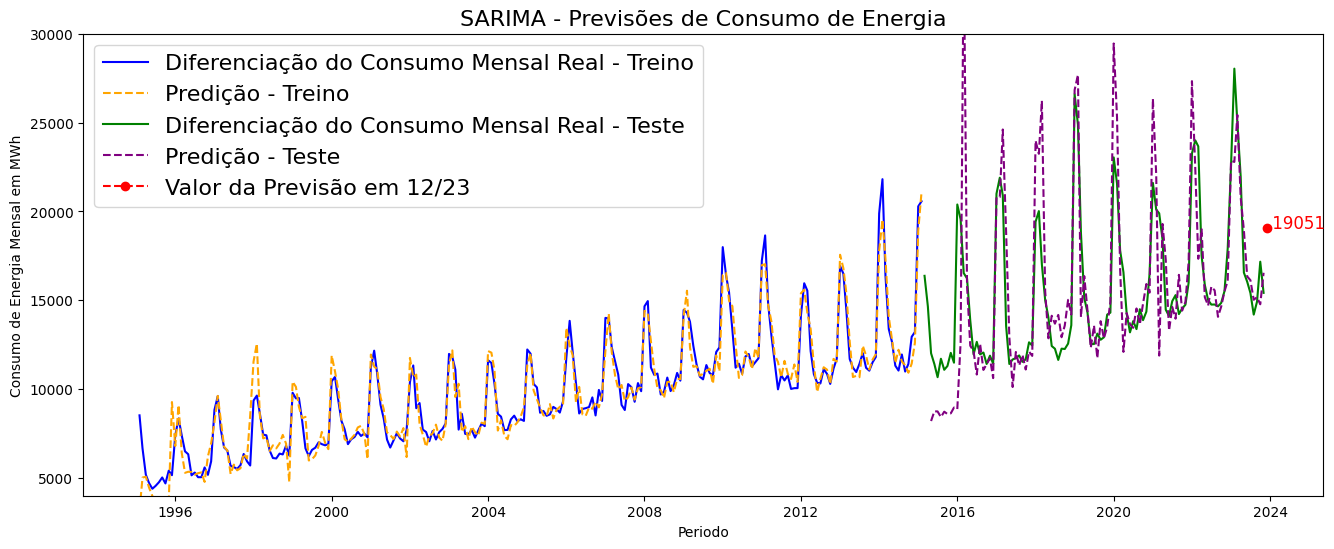

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(time_seriesf_residencial_sarima_train.iloc[2:].index, time_seriesf_residencial_sarima_train.iloc[2:]['consumo_mensal'], color="blue", label='Diferenciação do Consumo Mensal Real - Treino')
plt.plot(time_seriesf_residencial_sarima_train.iloc[2:].index, predictions_sarima_aic.iloc[2:], color="orange", linestyle="--",  label='Predição - Treino')
plt.plot(time_seriesf_residencial_sarima_test.index, time_seriesf_residencial_sarima_test['consumo_mensal'], color="green", label='Diferenciação do Consumo Mensal Real - Teste')
plt.plot(time_seriesf_residencial_sarima_test.iloc[2:].index, predictions_sarima_aic_test.iloc[2:], color="purple", linestyle="--", label='Predição - Teste')
plt.plot(forecast_sarima_aic, linestyle="--", marker='o', color='red', label='Valor da Previsão em 12/23')
plt.annotate(f" {int(forecast_sarima_aic[0])}", (forecast_sarima_aic.index[0], forecast_sarima_aic[0]), color="red", fontsize=12)
plt.ylim(4000, 30000)
plt.legend(fontsize=16)
plt.title('SARIMA - Previsões de Consumo de Energia', fontsize=18)
plt.xlabel('Periodo')
plt.ylabel('Consumo de Energia Mensal em MWh')

plt.annotate("o", (time_seriesf_residencial_sarima_train.iloc[:2].index[0], 30500), color="black", fontsize=16)
plt.annotate("o", (time_seriesf_residencial_sarima_train.iloc[:2].index[1], 55000), color="black", fontsize=16)
plt.annotate("o", (time_seriesf_residencial_sarima_test.iloc[:2].index[0], 30500), color="black", fontsize=16)
plt.annotate("o", (time_seriesf_residencial_sarima_test.iloc[:2].index[1], 75000), color="black", fontsize=16)
plt.show()

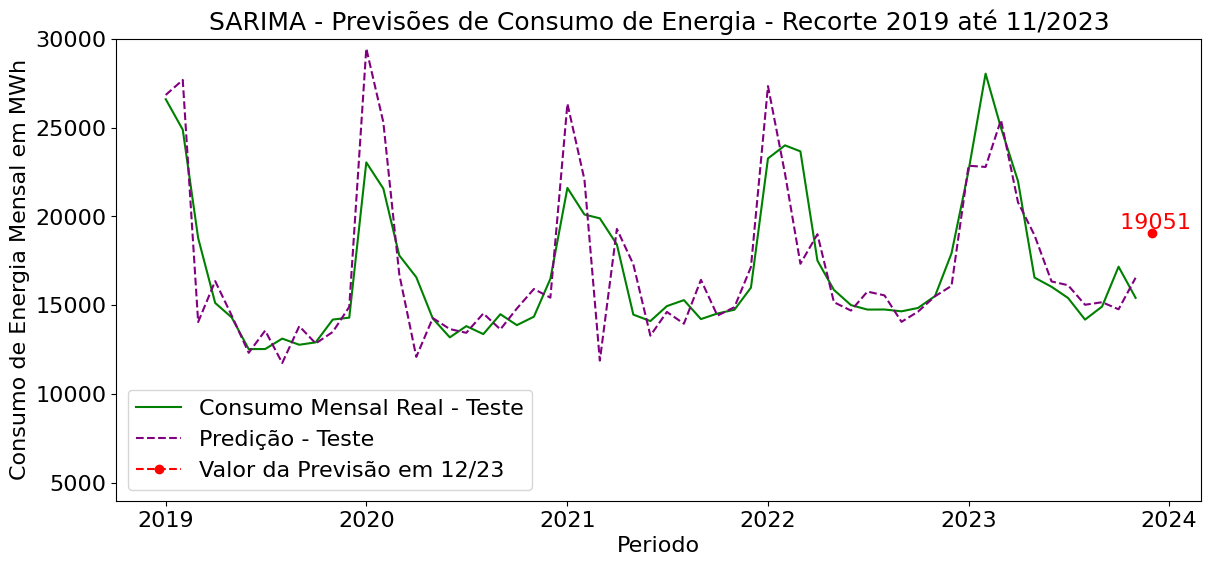

In [ ]:
recorte2019 = (time_seriesf_residencial_sarima_train.index.year > 2018)
recorte2019_2 = (time_seriesf_residencial_sarima_test.index.year > 2018)

plt.figure(figsize=(14, 6))
# plt.plot(time_seriesf_residencial_sarima_train[recorte2019].iloc[2:].index, time_seriesf_residencial_sarima_train[recorte2019].iloc[2:]['consumo_mensal'], color="blue", label='Consumo Mensal Real - Treino')
# plt.plot(time_seriesf_residencial_sarima_train[recorte2019].iloc[2:].index, predictions_sarima_aic[recorte2019].iloc[2:], color="orange", linestyle="--",  label='Predição - Treino')
plt.plot(time_seriesf_residencial_sarima_test[recorte2019_2].index, time_seriesf_residencial_sarima_test[recorte2019_2]['consumo_mensal'], color="green", label='Consumo Mensal Real - Teste')
plt.plot(time_seriesf_residencial_sarima_test[recorte2019_2].index, predictions_sarima_aic_test[recorte2019_2], color="purple", linestyle="--", label='Predição - Teste')
plt.plot(forecast_sarima_aic, linestyle="--", marker='o', color='red', label='Valor da Previsão em 12/23')
plt.annotate(f" {int(forecast_sarima_aic[0])}", (forecast_sarima_aic.index[0], forecast_sarima_aic[0]), color="red", fontsize=16, ha='center', va='bottom')
plt.ylim(4000, 30000)
plt.legend(fontsize=16)
plt.title('SARIMA - Previsões de Consumo de Energia - Recorte 2019 até 11/2023', fontsize=18)
plt.xlabel('Periodo', fontsize=16)
plt.ylabel('Consumo de Energia Mensal em MWh', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.annotate("o", (time_seriesf_residencial_sarima_test.iloc[:2].index[0], 60500), color="black", fontsize=16)
# plt.annotate("o", (time_seriesf_residencial_sarima_test.iloc[:2].index[1], 90000), color="black", fontsize=16)
plt.show()

## Metrica de Qualidade

In [ ]:
mse = mean_squared_error(time_seriesf_residencial_sarima_train['consumo_mensal'].iloc[2:], predictions_sarima_aic.iloc[2:])
print(f"MSE: {mse:.2f}")

r2 = r2_score(time_seriesf_residencial_sarima_train['consumo_mensal'].iloc[2:], predictions_sarima_aic.iloc[2:])
print("R2: ", r2)

print("SARIMA AIC", sarima.aic)

# MSE: 14919085.42
# R2:  0.051171635899114665
# SARIMA AIC 3554.9974115075393
# MSE: 9993137.32
# R2:  0.36445352582978763
# SARIMA AIC 3522.323029562442

MSE: 859723.95
R2:  0.9124314342465347
SARIMA AIC 1845.270206332896


In [ ]:
erro = (sarima.resid ** 2).mean()
erro

1033939.3629070859

## Grafico ACF e PACF do Residuo apos SARIMA

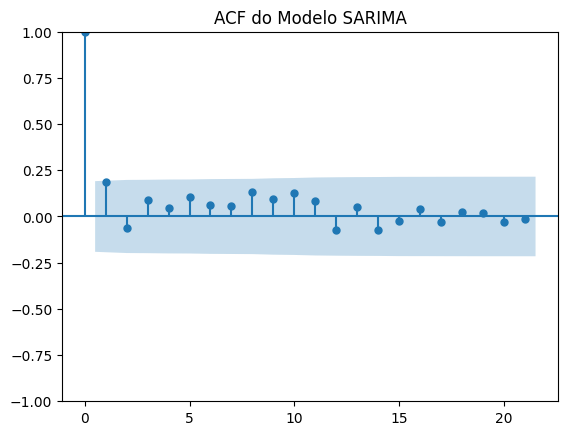

In [ ]:
plot_acf(sarima_test.resid)
plt.title("ACF do Modelo SARIMA")
plt.show()

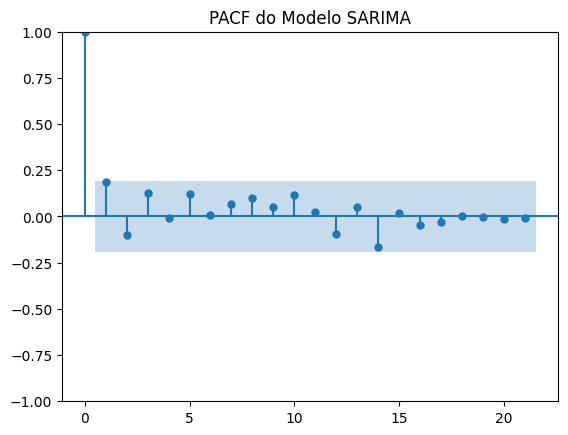

In [ ]:
plot_pacf(sarima_test.resid)
plt.title("PACF do Modelo SARIMA")
plt.show()

# SARIMAX MODEL

In [ ]:
time_seriesf_residencial_sarimax = time_seriesf_residencial.copy()

time_seriesf_residencial_sarimax['verao'] = np.where((time_seriesf_residencial_sarimax.month >= 1) & (time_seriesf_residencial_sarimax.month <= 3), 1, 0)
time_seriesf_residencial_sarimax['outono'] = np.where((time_seriesf_residencial_sarimax.month >= 4) & (time_seriesf_residencial_sarimax.month <= 6), 1, 0)
time_seriesf_residencial_sarimax['inverno'] = np.where((time_seriesf_residencial_sarimax.month >= 7) & (time_seriesf_residencial_sarimax.month <= 9), 1, 0)
time_seriesf_residencial_sarimax['primavera'] = np.where((time_seriesf_residencial_sarimax.month >= 10) & (time_seriesf_residencial_sarimax.month <= 12), 1, 0)
time_seriesf_residencial_sarimax.head()

,date,consumo_mensal,month,verao,outono,inverno,primavera
index_date,,,,,,,
1994-12-01,1994-12-01,4352.471,12,0,0,0,1
1995-01-01,1995-01-01,6272.489,1,1,0,0,0
1995-02-01,1995-02-01,8523.133,2,1,0,0,0
1995-03-01,1995-03-01,6667.975,3,1,0,0,0
1995-04-01,1995-04-01,5181.387,4,0,1,0,0


## Dividir os dados em treinamento e teste

In [ ]:
# Dividir os dados em treinamento e teste
train_size = int(len(time_seriesf_residencial_sarimax) * 0.7)
print("quantidade de treino:", train_size)
print("quantidade de teste:", len(time_seriesf_residencial_sarimax) - train_size)

time_seriesf_residencial_sarimax['date'] = pd.to_datetime(time_seriesf_residencial_sarimax['date'])
time_seriesf_residencial_sarimax.set_index('date', inplace=True)
time_seriesf_residencial_sarimax = time_seriesf_residencial_sarimax.asfreq('MS')
time_seriesf_residencial_sarimax

time_seriesf_residencial_sarimax_train = time_seriesf_residencial_sarimax[:train_size]
time_seriesf_residencial_sarimax_test = time_seriesf_residencial_sarimax[train_size:]
time_seriesf_residencial_sarimax_test.head()

quantidade de treino: 243
quantidade de teste: 105


,consumo_mensal,month,verao,outono,inverno,primavera
date,,,,,,
2015-03-01,16374.983,3,1,0,0,0
2015-04-01,14657.350,4,0,1,0,0
2015-05-01,12016.341,5,0,1,0,0
2015-06-01,11405.417,6,0,1,0,0
2015-07-01,10670.310,7,0,0,1,0


## Grid Search com AIC

In [ ]:
import itertools

p = q = [2,6,12]
d = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

best_aic = np.inf
best_order = None
best_seasonal_order = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
            model_grid_sarimax = sm.tsa.SARIMAX(time_seriesf_residencial_sarimax_train.consumo_mensal, order=(p, d, q), seasonal_order=(P, D, Q, s), enforce_stationarity=False, enforce_invertibility=False, , exog=time_seriesf_residencial_sarimax_test[['verao', 'outono', 'inverno', 'primavera']])

            results = model_grid_sarimax.fit()

            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = param_seasonal

print(f"Melhor configuração de SARIMAX: (p,d,q) = {best_order}, (P,D,Q,s) = {best_seasonal_order}")

In [ ]:
# p_values = [1,2,3,4,6,9,12]
# d_values = range(0, 3)
# q_values = [1,2,3,4,6,9,12]
# P_values = [1,2,3,4,6,9,12]
# D_values = range(0, 3)
# Q_values = [1,2,3,4,6,9,12]
# s = 12

# best_sarimax_aic = 0
# best_sarimax_order_aic = None

# for p in p_values:
#   for d in d_values:
#     for q in q_values:
#       for P in P_values:
#         for D in D_values:
#           for Q in Q_values:
#             order = (p, d, q, P, D, Q, s)
#             print("Grid Search Sarima, Order: (",p,d,q,")", "seasonal_order=(",P, D, Q, s,")")
#             if(q >= s):
#               # as medias moveis que é o q não pode ser igual ou maior que o s que é periocidade
#               print("Pula devido ao esse erro: Invalid model: moving average lag(s) {",q,"} are in both the seasonal and non-seasonal moving average components.")
#               continue
#             if(p >= s):
#               # o lag autoregresso que é o p não pode ser igual ou maior que o s que é periocidade
#               print("Pula devido ao esse erro: Invalid model: autoregressive lag(s) {",p,"} are in both the seasonal and non-seasonal autoregressive components.")
#               continue
#             model_grid_sarimax = sm.tsa.SARIMAX(time_seriesf_residencial_sarimax_train.consumo_mensal, order=(p, d, q), seasonal_order=(P, D, Q, s), enforce_stationarity=False, enforce_invertibility=False, exog=time_seriesf_residencial_sarimax_train.index.month)
#             model_grid_sarimax = model_grid_sarimax.fit()
#             aic = model_grid_sarimax.aic
#             print("aic: ", aic)
#             if aic < best_sarimax_aic:
#               best_aic = aic
#               best_sarimax_order_aic = order

# print("Melhor ordem SARIMAX:", best_sarimax_order_aic)



In [ ]:
# Grid Search Sarima, Order: ( 1 0 1 ) seasonal_order=( 2 2 9 12 )
# aic:  1845.270206332896
sarimax = sm.tsa.SARIMAX(time_seriesf_residencial_sarimax_train.consumo_mensal, order=(1, 0, 1), seasonal_order=(2, 2, 9, 12), exog=time_seriesf_residencial_sarimax_train[['verao', 'outono', 'inverno', 'primavera']])
sarimax = sarimax.fit()

sarimax_test = sm.tsa.SARIMAX(time_seriesf_residencial_sarimax_test.consumo_mensal, order=(1, 0, 1), seasonal_order=(2, 2, 9, 12), exog=time_seriesf_residencial_sarimax_test[['verao', 'outono', 'inverno', 'primavera']])
with sarimax_test.fix_params(sarimax.params):
        sarimax_test = sarimax_test.fit()

predictions_sarimax_aic = sarimax.predict()
predictions_sarimax_aic_test = sarimax_test.predict()

In [ ]:
forecast_sarimax_aic = sarimax_test.forecast(steps=1, exog=[0,0,1,0])
forecast_sarimax_aic

2023-12-01    19139.6172
Freq: MS, dtype: float64

NameError: name 'forecast_sarimax_aic' is not defined

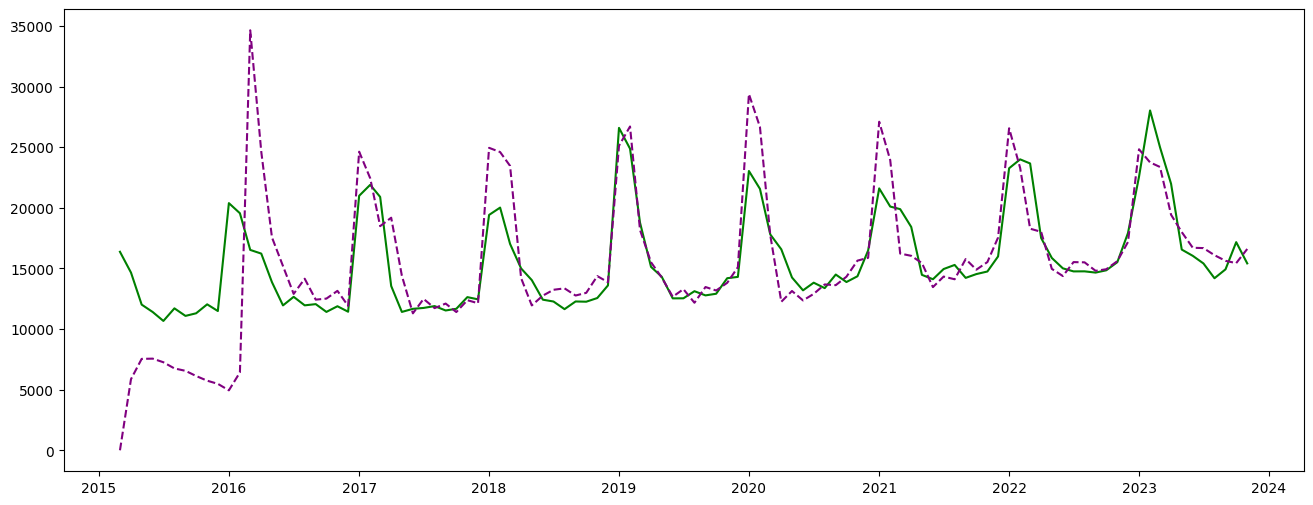

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(time_seriesf_residencial_sarimax_train.iloc[2:].index, time_seriesf_residencial_sarimax_train.iloc[2:]['consumo_mensal'], color="blue", label='Diferenciação do Consumo Mensal Real - Treino')
plt.plot(time_seriesf_residencial_sarimax_train.iloc[2:].index, predictions_sarimax_aic.iloc[2:], color="orange", linestyle="--",  label='Predição - Treino')
plt.plot(time_seriesf_residencial_sarimax_test.index, time_seriesf_residencial_sarimax_test['consumo_mensal'], color="green", label='Diferenciação do Consumo Mensal Real - Teste')
plt.plot(time_seriesf_residencial_sarimax_test.iloc[2:].index, predictions_sarimax_aic_test.iloc[2:], color="purple", linestyle="--", label='Predição - Teste')
plt.plot(forecast_sarimax_aic, linestyle="--", marker='o', color='red', label='Valor da Previsão em 12/23')
plt.annotate(f" {int(forecast_sarimax_aic[0])}", (forecast_sarimax_aic.index[0], forecast_sarimax_aic[0]), color="red", fontsize=11)
plt.ylim(4000, 35000)
plt.legend(fontsize=16)
plt.title('SARIMAX - Previsões de Consumo de Energia', fontsize=16)
plt.xlabel('Periodo')
plt.ylabel('Consumo de Energia Mensal em MWh')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.annotate("o", (time_seriesf_residencial_sarimax_train.iloc[:2].index[0], 30500), color="black", fontsize=16)
# plt.annotate("o", (time_seriesf_residencial_sarimax_train.iloc[:2].index[1], 55000), color="black", fontsize=16)
# plt.annotate("o", (time_seriesf_residencial_sarimax_test.iloc[:2].index[0], 30500), color="black", fontsize=16)
# plt.annotate("o", (time_seriesf_residencial_sarimax_test.iloc[:2].index[1], 75000), color="black", fontsize=16)
plt.show()

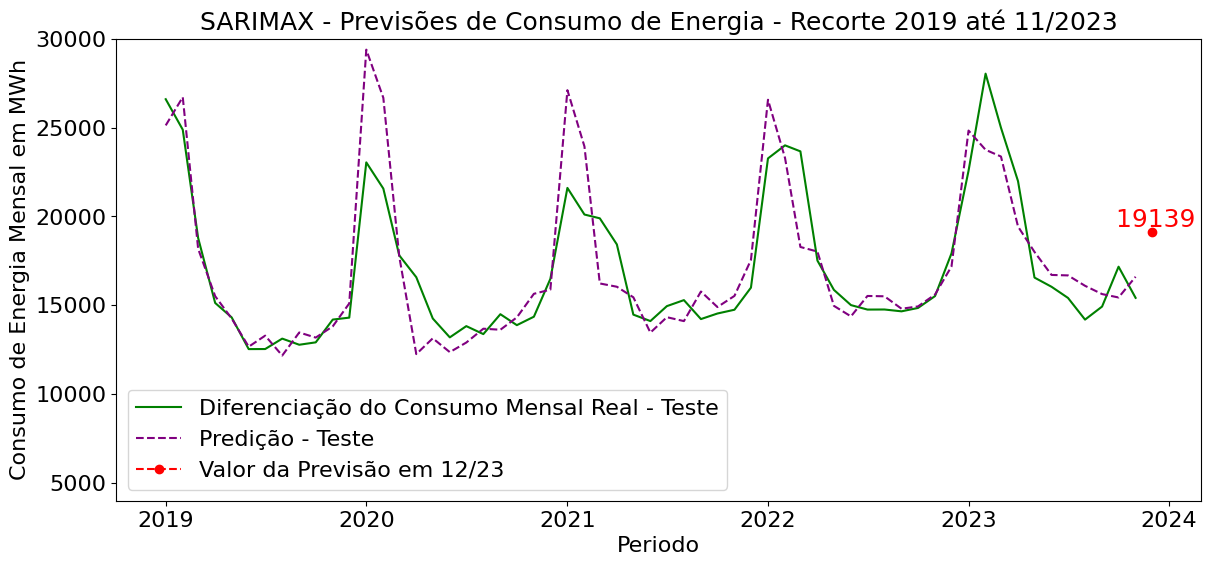

In [ ]:
recorte2019 = (time_seriesf_residencial_sarimax_train.index.year > 2018)
recorte2019_2 = (time_seriesf_residencial_sarimax_test.index.year > 2018)


plt.figure(figsize=(14, 6))
# plt.plot(time_seriesf_residencial_sarimax_train[recorte2019].iloc[2:].index, time_seriesf_residencial_sarimax_train[recorte2019].iloc[2:]['consumo_mensal'], color="blue", label='Diferenciação do Consumo Mensal Real - Treino')
# plt.plot(time_seriesf_residencial_sarimax_train[recorte2019].iloc[2:].index, predictions_sarimax_aic[recorte2019].iloc[2:], color="orange", linestyle="--",  label='Predição - Treino')
plt.plot(time_seriesf_residencial_sarimax_test[recorte2019_2].index, time_seriesf_residencial_sarimax_test[recorte2019_2]['consumo_mensal'], color="green", label='Diferenciação do Consumo Mensal Real - Teste')
plt.plot(time_seriesf_residencial_sarimax_test[recorte2019_2].index, predictions_sarimax_aic_test[recorte2019_2], color="purple", linestyle="--", label='Predição - Teste')
plt.plot(forecast_sarimax_aic, linestyle="--", marker='o', color='red', label='Valor da Previsão em 12/23')
plt.annotate(f" {int(forecast_sarimax_aic[0])}", (forecast_sarimax_aic.index[0], forecast_sarimax_aic[0]), color="red", fontsize=18, ha='center', va='bottom')
plt.ylim(4000, 30000)
plt.legend(fontsize=16)
plt.title('SARIMAX - Previsões de Consumo de Energia - Recorte 2019 até 11/2023', fontsize=18)
plt.xlabel('Periodo', fontsize=16)
plt.ylabel('Consumo de Energia Mensal em MWh', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.annotate("o", (time_seriesf_residencial_sarimax_test.iloc[:2].index[0], 60500), color="black", fontsize=16)
# plt.annotate("o", (time_seriesf_residencial_sarimax_test.iloc[:2].index[1], 70000), color="black", fontsize=16)
plt.show()

## Metrica de Qualidade

In [ ]:
mse = mean_squared_error(time_seriesf_residencial_sarimax_train['consumo_mensal'].iloc[2:], predictions_sarimax_aic.iloc[2:])
print(f"MSE: {mse:.2f}")

r2 = r2_score(time_seriesf_residencial_sarimax_train['consumo_mensal'].iloc[2:], predictions_sarimax_aic.iloc[2:])
print("R2: ", r2)

print("SARIMAX AIC", sarimax.aic)

MSE: 1105696.43
R2:  0.8873775120514465
SARIMAX AIC 3686.9523151808016


## Grafico ACF e PACF do Residuo apos SARIMAX

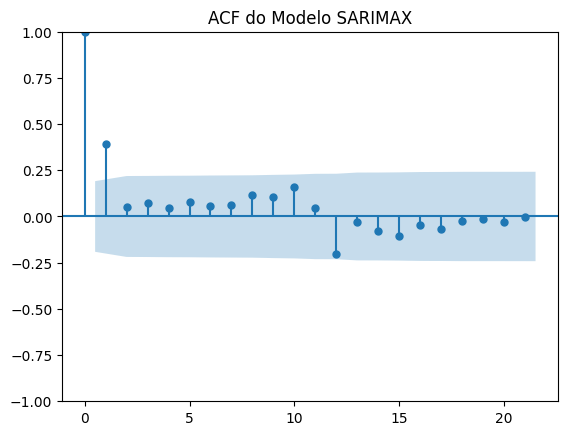

In [ ]:
plot_acf(sarimax_test.resid)
plt.title("ACF do Modelo SARIMAX")
plt.show()

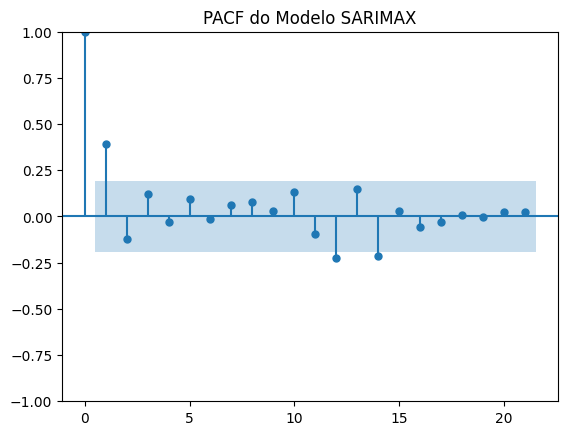

In [ ]:
plot_pacf(sarimax_test.resid)
plt.title("PACF do Modelo SARIMAX")
plt.show()

# LSTM

###Normalização dos dados

In [18]:
time_seriesf_residencial_lstm = time_seriesf_residencial.copy()

time_seriesf_residencial_lstm_norm = time_seriesf_residencial_lstm['consumo_mensal'].values
time_seriesf_residencial_lstm_norm = time_seriesf_residencial_lstm_norm.astype('float32').reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
time_seriesf_residencial_lstm_norm = scaler.fit_transform(time_seriesf_residencial_lstm_norm)

In [19]:
# Split into train and test sets

train_size = int(len(time_seriesf_residencial_lstm_norm) * 2/3)
test_size = len(time_seriesf_residencial_lstm_norm) - train_size
time_seriesf_residencial_lstm_train, time_seriesf_residencial_lstm_test = time_seriesf_residencial_lstm_norm[0:train_size,:], time_seriesf_residencial_lstm_norm[train_size:len(time_seriesf_residencial_lstm_norm),:]

In [20]:
time_seriesf_residencial_lstm['consumo_mensal'][test_size:]

index_date
2004-08-01     8294.346
2004-09-01     8505.437
2004-10-01     8192.059
2004-11-01     8301.615
2004-12-01     8210.342
                ...    
2023-07-01    15412.302
2023-08-01    14192.559
2023-09-01    14927.108
2023-10-01    17170.480
2023-11-01    15416.700
Freq: MS, Name: consumo_mensal, Length: 232, dtype: float64

In [21]:
recorte2019_2 = (time_seriesf_residencial_lstm.index.year > 2018)
data_number = time_seriesf_residencial_lstm[recorte2019_2].count()

In [22]:
def create_sequence(dataset, n_steps=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-n_steps-1):
    a = dataset[i:(i+n_steps), 0]
    dataX.append(a)
    dataY.append(dataset[i + n_steps, 0])
 return np.array(dataX), np.array(dataY)

In [23]:
# reshape input to be [samples, time steps, features]

n_steps = 1
X_train, y_train = create_sequence(time_seriesf_residencial_lstm_train, n_steps)
X_test, y_test = create_sequence(time_seriesf_residencial_lstm_test, n_steps)

#The LSTM network expects the input data (X) to be provided with a specific array structure in the form of [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


###Grid Search LSTM

In [24]:
!pip install scikeras

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

# Função para criar o modelo Keras que será usada no Grid Search
def create_lstm_model(units=50):
    model = Sequential()
    model.add(LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Crie o modelo KerasRegressor
model = KerasRegressor(build_fn=create_lstm_model, epochs=100, units=50, verbose=0)

# Defina os hiperparâmetros que deseja otimizar
param_grid = {
    'units': [50, 100],  # Varie o número de unidades LSTM
    'epochs': [50, 100],  # Varie o número de épocas de treinamento
    'batch_size': [32, 64]  # Varie o tamanho do lote
}

# Realize o Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_result = grid.fit(X_train, y_train)

# Exiba os melhores resultados
print("Melhores hiperparâmetros encontrados: ", grid_result.best_params_)
print("Melhor MSE encontrado: ", grid_result.best_score_)

KeyboardInterrupt: 

###Modelo

In [26]:
lstm = Sequential()
lstm.add(LSTM(100, input_shape=(1, n_steps)))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
lstm.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)

Epoch 1/100
8/8 - 3s - loss: 0.0561 - mean_squared_error: 0.0561 - 3s/epoch - 388ms/step
Epoch 2/100
8/8 - 0s - loss: 0.0393 - mean_squared_error: 0.0393 - 69ms/epoch - 9ms/step
Epoch 3/100
8/8 - 0s - loss: 0.0270 - mean_squared_error: 0.0270 - 94ms/epoch - 12ms/step
Epoch 4/100
8/8 - 0s - loss: 0.0178 - mean_squared_error: 0.0178 - 108ms/epoch - 13ms/step
Epoch 5/100
8/8 - 0s - loss: 0.0133 - mean_squared_error: 0.0133 - 63ms/epoch - 8ms/step
Epoch 6/100
8/8 - 0s - loss: 0.0110 - mean_squared_error: 0.0110 - 63ms/epoch - 8ms/step
Epoch 7/100
8/8 - 0s - loss: 0.0108 - mean_squared_error: 0.0108 - 56ms/epoch - 7ms/step
Epoch 8/100
8/8 - 0s - loss: 0.0106 - mean_squared_error: 0.0106 - 45ms/epoch - 6ms/step
Epoch 9/100
8/8 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - 61ms/epoch - 8ms/step
Epoch 10/100
8/8 - 0s - loss: 0.0099 - mean_squared_error: 0.0099 - 46ms/epoch - 6ms/step
Epoch 11/100
8/8 - 0s - loss: 0.0096 - mean_squared_error: 0.0096 - 46ms/epoch - 6ms/step
Epoch 12/100
8/8

In [27]:
predictions_lstm_train = lstm.predict(X_train)
predictions_lstm_test = lstm.predict(X_test)

4/4 [==============================] - 0s 4ms/step


In [28]:
latest_data = predictions_lstm_test[-1]

latest_data = latest_data.reshape(1, 1, n_steps)

forecast = lstm.predict(latest_data)
forecast = forecast.reshape(-1, 1)

1/1 [==============================] - 0s 31ms/step


In [29]:
#invert predictions
train_inverse = scaler.inverse_transform([y_train])
predict_train_inverse = scaler.inverse_transform(predictions_lstm_train)
test_inverse = scaler.inverse_transform([y_test])
predict_test_inverse = scaler.inverse_transform(predictions_lstm_test)

In [30]:
mse = mean_squared_error(test_inverse[0], predict_test_inverse[:,0])
print("MSE", mse)

r2 = r2_score(test_inverse[0], predict_test_inverse[:,0])
print("R2: ", r2)

MSE 8787984.08308468
R2:  0.4364312738880579


In [31]:
forecast_inverse = scaler.inverse_transform(forecast)

In [32]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(time_seriesf_residencial_lstm_norm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_steps:len(predict_train_inverse)+n_steps, :] = predict_train_inverse

# shift test predictions for plotting
testPredictPlot = np.empty_like(time_seriesf_residencial_lstm_norm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(predict_train_inverse)+(n_steps*2)+1:len(time_seriesf_residencial_lstm_norm)-1, :] = predict_test_inverse

testForecastPlot = np.empty_like(time_seriesf_residencial_lstm_norm)
testForecastPlot[:, :] = np.nan
testForecastPlot[-1] = forecast_inverse[0]

In [33]:
testForecastPlot[-1][0]

13617.44

## Grafico

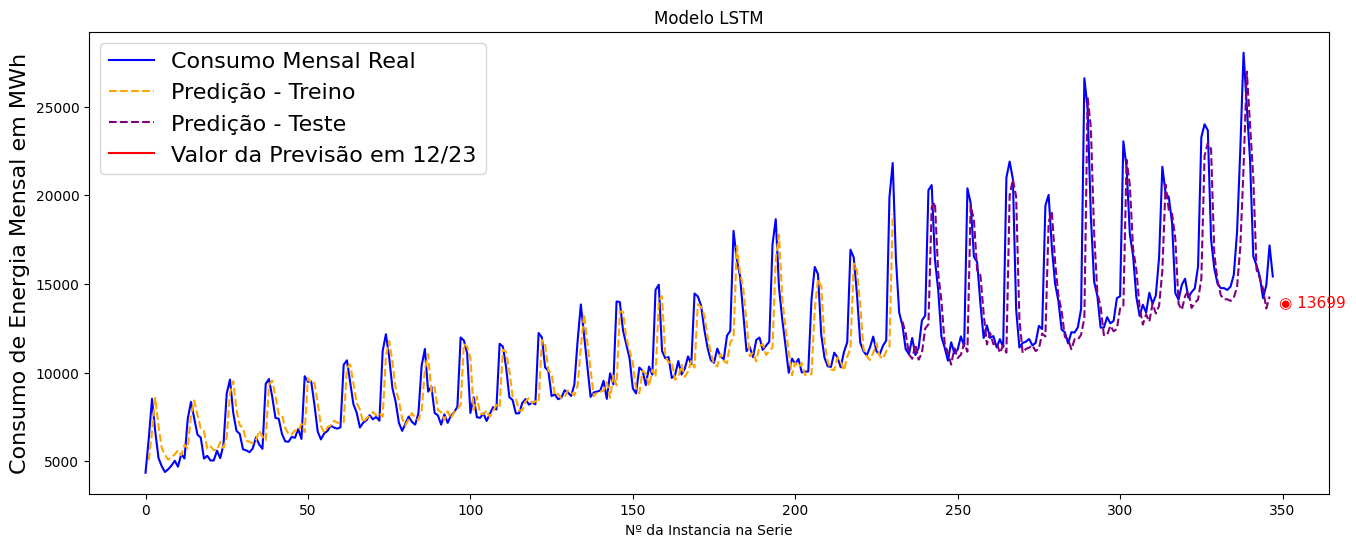

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(scaler.inverse_transform(time_seriesf_residencial_lstm_norm), color="blue", label='Consumo Mensal Real')
plt.plot(trainPredictPlot, color="orange", linestyle="--",  label='Predição - Treino')
plt.plot(testPredictPlot, color="purple", linestyle="--", label='Predição - Teste')
plt.plot(testForecastPlot, color="red", label='Valor da Previsão em 12/23')
plt.title('Modelo LSTM')
plt.xlabel('Nº da Instancia na Serie')
plt.annotate(f"◉ {int(testForecastPlot[-1][0])}", (349, testForecastPlot[-1][0]), color="red", fontsize=11)
plt.ylabel('Consumo de Energia Mensal em MWh', fontsize=16)
plt.legend(fontsize=16)
plt.show()

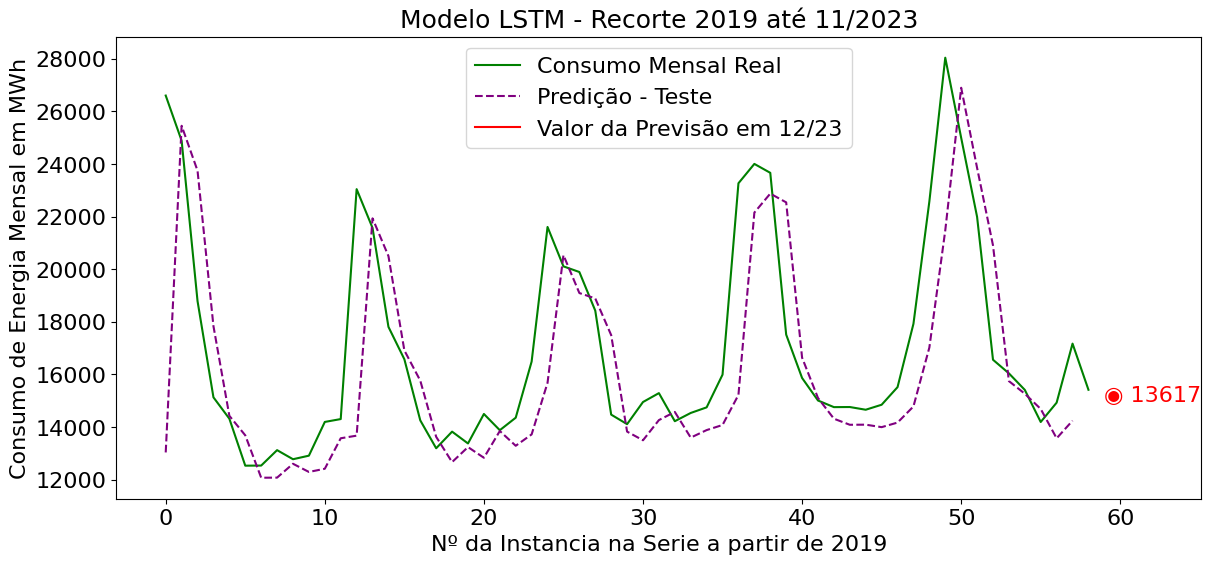

In [34]:
plt.figure(figsize=(14, 6))
plt.plot(scaler.inverse_transform(time_seriesf_residencial_lstm_norm)[230:][59:], color="green", label='Consumo Mensal Real')
# plt.plot(trainPredictPlot[230:], color="orange", linestyle="--",  label='Predição - Treino')
plt.plot(testPredictPlot[230:][59:], color="purple", linestyle="--", label='Predição - Teste')
plt.plot(testForecastPlot[230:][55:], color="red", label='Valor da Previsão em 12/23')
plt.title('Modelo LSTM - Recorte 2019 até 11/2023', fontsize=18)
plt.xlabel('Nº da Instancia na Serie a partir de 2019', fontsize=16)
plt.annotate(f"◉ {int(testForecastPlot[-1][0])}", (62, testForecastPlot[-1][0]+1200), color="red", fontsize=16, ha='center', va='bottom' )
plt.ylabel('Consumo de Energia Mensal em MWh', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()